<a href="https://colab.research.google.com/github/smeenamanian89/Articles/blob/main/CBH_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

file_path = '/content/Problems we tackle, Shift Offers v3.xlsx'
df = pd.read_excel(file_path)

display(df.head())

## Data cleaning and preprocessing

### Subtask:
Handle missing values, convert data types (especially date/time columns), and address any inconsistencies in the data.


**Reasoning**:
Inspect the DataFrame to identify missing values and data types, and convert date/time columns to datetime objects.



In [ ]:
display(df.info())

datetime_columns = ['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'CLAIMED_AT', 'DELETED_AT', 'CANCELED_AT']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

display(df.head())

**Reasoning**:
Address missing values, examine and standardize the 'SLOT' column, and check for duplicate rows.



In [ ]:
# Missing values in CLAIMED_AT, DELETED_AT, CANCELED_AT indicate the event did not occur,
# so we will leave them as NaT (Not a Time).
# No other columns have missing values based on the info() output.

# Examine 'SLOT' column for unique values
display(df['SLOT'].unique())

# Standardize 'SLOT' if necessary. Assuming 'am' and 'pm' are the only expected values.
# If there were other inconsistencies, we would address them here.

# Check for duplicate rows
display(f"Number of duplicate rows: {df.duplicated().sum()}")

# No action needed for duplicates if the count is 0, otherwise drop them:
# df.drop_duplicates(inplace=True)

**Reasoning**:
Drop the single duplicate row identified and then finish the task as the data cleaning steps are complete.



In [ ]:
df.drop_duplicates(inplace=True)
display(f"Number of duplicate rows after dropping: {df.duplicated().sum()}")

## Feature engineering

### Subtask:
Create new features that could be relevant for analysis, such as lead time (time between shift creation and start), duration of shift, day of the week, etc.


**Reasoning**:
Calculate lead time, extract day of week and hour of day, calculate time differences for viewing and claiming offers, and calculate pay and charge rates per hour, storing these in new columns as per the instructions.



In [ ]:
# 1. Calculate lead time in hours
df['lead_time_hours'] = (df['SHIFT_START_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600

# 2. Extract day of the week
df['day_of_week'] = df['SHIFT_START_AT'].dt.day_name()

# 3. Extract hour of the day
df['hour_of_day'] = df['SHIFT_START_AT'].dt.hour

# 4. Calculate view time in hours (fill NaT with a large value or -1)
df['view_time_hours'] = (df['OFFER_VIEWED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['view_time_hours'].fillna(-1, inplace=True) # Use -1 to indicate not viewed

# 5. Calculate claim time from viewed in hours (fill NaT with -1)
df['claim_time_hours'] = (df['CLAIMED_AT'] - df['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
df['claim_time_hours'].fillna(-1, inplace=True) # Use -1 to indicate not claimed after viewing

# 6. Calculate claim time from created in hours (fill NaT with -1)
df['claim_from_created_time_hours'] = (df['CLAIMED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['claim_from_created_time_hours'].fillna(-1, inplace=True) # Use -1 to indicate not claimed at all

# 7. Calculate pay rate per hour
df['pay_rate_per_hour'] = df['PAY_RATE'] / df['DURATION']

# 8. Calculate charge rate per hour
df['charge_rate_per_hour'] = df['CHARGE_RATE'] / df['DURATION']

display(df[['lead_time_hours', 'day_of_week', 'hour_of_day', 'view_time_hours', 'claim_time_hours', 'claim_from_created_time_hours', 'pay_rate_per_hour', 'charge_rate_per_hour']].head())

## Analyze shift offer acceptance/rejection

### Subtask:
Investigate which factors influence whether a shift offer is viewed, claimed, or canceled.


**Reasoning**:
Create boolean columns for 'is_viewed', 'is_claimed', and 'is_canceled' and calculate the proportion of each.



In [ ]:
# 1. Create new boolean columns
df['is_viewed'] = df['OFFER_VIEWED_AT'].notna()
df['is_claimed'] = df['CLAIMED_AT'].notna()
df['is_canceled'] = df['CANCELED_AT'].notna()

# 2. Calculate the proportion of offers viewed, claimed, and canceled
viewed_proportion = df['is_viewed'].mean()
claimed_proportion = df['is_claimed'].mean()
canceled_proportion = df['is_canceled'].mean()

print(f"Proportion of offers viewed: {viewed_proportion:.4f}")
print(f"Proportion of offers claimed: {claimed_proportion:.4f}")
print(f"Proportion of offers canceled: {canceled_proportion:.4f}")

**Reasoning**:
Analyze the relationship between engineered features and the 'is_viewed', 'is_claimed', and 'is_canceled' columns by grouping and aggregating data.



In [ ]:
# 3. Analyze the relationship between engineered features and the boolean columns

# Relationship with day_of_week
day_of_week_analysis = df.groupby('day_of_week')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()
print("Analysis by Day of Week:")
display(day_of_week_analysis)

# Relationship with hour_of_day (binning for better analysis if too many hours)
# Let's group hours into 4-hour bins
hour_bins = range(0, 28, 4) # Creates bins [0, 4), [4, 8), ..., [24, 28)
df['hour_bin'] = pd.cut(df['hour_of_day'], bins=hour_bins, right=False, include_lowest=True)
hour_of_day_analysis = df.groupby('hour_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()
print("\nAnalysis by Hour of Day (4-hour bins):")
display(hour_of_day_analysis)

# Relationship with lead_time_hours (binning)
# Let's create bins for lead time
lead_time_bins = [-1] + list(range(0, int(df['lead_time_hours'].max()) + 50, 50)) # Create bins e.g., [-1, 0), [0, 50), [50, 100)...
df['lead_time_bin'] = pd.cut(df['lead_time_hours'], bins=lead_time_bins, right=False, include_lowest=True)
lead_time_analysis = df.groupby('lead_time_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()
print("\nAnalysis by Lead Time (hours bins):")
display(lead_time_analysis)


# Relationship with pay_rate_per_hour (binning)
# Let's create bins for pay rate per hour
pay_rate_bins = [-1] + list(range(0, int(df['pay_rate_per_hour'].max()) + 5, 5)) # Create bins e.g., [-1, 0), [0, 5), [5, 10)...
df['pay_rate_bin'] = pd.cut(df['pay_rate_per_hour'], bins=pay_rate_bins, right=False, include_lowest=True)
pay_rate_analysis = df.groupby('pay_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()
print("\nAnalysis by Pay Rate Per Hour (bins):")
display(pay_rate_analysis)

# Relationship with charge_rate_per_hour (binning)
# Let's create bins for charge rate per hour
charge_rate_bins = [-1] + list(range(0, int(df['charge_rate_per_hour'].max()) + 5, 5)) # Create bins e.g., [-1, 0), [0, 5), [5, 10)...
df['charge_rate_bin'] = pd.cut(df['charge_rate_per_hour'], bins=charge_rate_bins, right=False, include_lowest=True)
charge_rate_analysis = df.groupby('charge_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()
print("\nAnalysis by Charge Rate Per Hour (bins):")
display(charge_rate_analysis)

**Reasoning**:
An OverflowError occurred when trying to create bins for 'pay_rate_per_hour', likely due to an infinite value in the column's max. I will inspect the 'pay_rate_per_hour' column for problematic values and then retry the binning and analysis.



In [ ]:
# Inspect the 'pay_rate_per_hour' column for non-finite values
display(df[~np.isfinite(df['pay_rate_per_hour'])])

# Replace infinite values or handle them appropriately before binning
# For simplicity, let's replace inf values with a large number or the max finite value
max_finite_pay_rate = df[np.isfinite(df['pay_rate_per_hour'])]['pay_rate_per_hour'].max()
df['pay_rate_per_hour'] = np.where(np.isinf(df['pay_rate_per_hour']), max_finite_pay_rate, df['pay_rate_per_hour'])


# Retry Relationship with pay_rate_per_hour (binning)
# Let's create bins for pay rate per hour
pay_rate_bins = [-1] + list(range(0, int(df['pay_rate_per_hour'].max()) + 5, 5)) # Create bins e.g., [-1, 0), [0, 5), [5, 10)...
df['pay_rate_bin'] = pd.cut(df['pay_rate_per_hour'], bins=pay_rate_bins, right=False, include_lowest=True)
pay_rate_analysis = df.groupby('pay_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()
print("\nAnalysis by Pay Rate Per Hour (bins):")
display(pay_rate_analysis)

# Retry Relationship with charge_rate_per_hour (binning)
# Inspect the 'charge_rate_per_hour' column for non-finite values
display(df[~np.isfinite(df['charge_rate_per_hour'])])

# Replace infinite values or handle them appropriately before binning
max_finite_charge_rate = df[np.isfinite(df['charge_rate_per_hour'])]['charge_rate_per_hour'].max()
df['charge_rate_per_hour'] = np.where(np.isinf(df['charge_rate_per_hour']), max_finite_charge_rate, df['charge_rate_per_hour'])

# Let's create bins for charge rate per hour
charge_rate_bins = [-1] + list(range(0, int(df['charge_rate_per_hour'].max()) + 5, 5)) # Create bins e.g., [-1, 0), [0, 5), [5, 10)...
df['charge_rate_bin'] = pd.cut(df['charge_rate_per_hour'], bins=charge_rate_bins, right=False, include_lowest=True)
charge_rate_analysis = df.groupby('charge_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()
print("\nAnalysis by Charge Rate Per Hour (bins):")
display(charge_rate_analysis)

**Reasoning**:
A NameError occurred because the numpy library was not imported. I need to import numpy to use `np.isfinite` and `np.where`. Then I will retry the analysis for pay rate and charge rate per hour.



In [2]:
import numpy as np

# Inspect the 'pay_rate_per_hour' column for non-finite values
display(df[~np.isfinite(df['pay_rate_per_hour'])])

# Replace infinite values or handle them appropriately before binning
# For simplicity, let's replace inf values with a large number or the max finite value
max_finite_pay_rate = df[np.isfinite(df['pay_rate_per_hour'])]['pay_rate_per_hour'].max()
df['pay_rate_per_hour'] = np.where(np.isinf(df['pay_rate_per_hour']), max_finite_pay_rate, df['pay_rate_per_hour'])


# Retry Relationship with pay_rate_per_hour (binning)
# Let's create bins for pay rate per hour
pay_rate_bins = [-1] + list(range(0, int(df['pay_rate_per_hour'].max()) + 5, 5)) # Create bins e.g., [-1, 0), [0, 5), [5, 10)...
df['pay_rate_bin'] = pd.cut(df['pay_rate_per_hour'], bins=pay_rate_bins, right=False, include_lowest=True)
pay_rate_analysis = df.groupby('pay_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()
print("\nAnalysis by Pay Rate Per Hour (bins):")
display(pay_rate_analysis)

# Retry Relationship with charge_rate_per_hour (binning)
# Inspect the 'charge_rate_per_hour' column for non-finite values
display(df[~np.isfinite(df['charge_rate_per_hour'])])

# Replace infinite values or handle them appropriately before binning
max_finite_charge_rate = df[np.isfinite(df['charge_rate_per_hour'])]['charge_rate_per_hour'].max()
df['charge_rate_per_hour'] = np.where(np.isinf(df['charge_rate_per_hour']), max_finite_charge_rate, df['charge_rate_per_hour'])

# Let's create bins for charge rate per hour
charge_rate_bins = [-1] + list(range(0, int(df['charge_rate_per_hour'].max()) + 5, 5)) # Create bins e.g., [-1, 0), [0, 5), [5, 10)...
df['charge_rate_bin'] = pd.cut(df['charge_rate_per_hour'], bins=charge_rate_bins, right=False, include_lowest=True)
charge_rate_analysis = df.groupby('charge_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()
print("\nAnalysis by Charge Rate Per Hour (bins):")
display(charge_rate_analysis)

NameError: name 'df' is not defined

**Reasoning**:
Visualize the relationships between the engineered features and the 'is_claimed' column to gain insights into factors influencing shift claims. I will focus on 'day_of_week', 'hour_bin', 'lead_time_bin', 'pay_rate_bin', and 'charge_rate_bin' as 'is_viewed' is mostly 1.0.



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Visualize the relationships

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot Claim Rate by Day of Week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='is_claimed', data=day_of_week_analysis, palette='viridis')
plt.title('Claim Rate by Day of Week')
plt.ylabel('Claim Rate')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Claim Rate by Hour of Day Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='hour_bin', y='is_claimed', data=hour_of_day_analysis, palette='viridis')
plt.title('Claim Rate by Hour of Day')
plt.ylabel('Claim Rate')
plt.xlabel('Hour of Day Bin')
plt.tight_layout()
plt.show()

# Plot Claim Rate by Lead Time Bin
plt.figure(figsize=(12, 6))
sns.barplot(x='lead_time_bin', y='is_claimed', data=lead_time_analysis, palette='viridis')
plt.title('Claim Rate by Lead Time')
plt.ylabel('Claim Rate')
plt.xlabel('Lead Time (hours) Bin')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot Claim Rate by Pay Rate Per Hour Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='pay_rate_bin', y='is_claimed', data=pay_rate_analysis, palette='viridis')
plt.title('Claim Rate by Pay Rate Per Hour')
plt.ylabel('Claim Rate')
plt.xlabel('Pay Rate Per Hour Bin')
plt.tight_layout()
plt.show()

# Plot Claim Rate by Charge Rate Per Hour Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='charge_rate_bin', y='is_claimed', data=charge_rate_analysis, palette='viridis')
plt.title('Claim Rate by Charge Rate Per Hour')
plt.ylabel('Claim Rate')
plt.xlabel('Charge Rate Per Hour Bin')
plt.tight_layout()
plt.show()

## Analyze worker behavior

### Subtask:
Understand patterns in worker behavior, such as which workers claim shifts, how quickly they claim them, and their reliability (e.g., cancellation rates).


**Reasoning**:
Group the DataFrame by 'WORKER_ID' and calculate the count of shifts offered, and the sum of viewed, claimed, and canceled shifts for each worker. Then calculate the rates and analyze their distribution.



In [3]:
# 1. Group by 'WORKER_ID' and calculate counts and sums
worker_behavior = df.groupby('WORKER_ID').agg(
    shifts_offered=('SHIFT_ID', 'count'),
    shifts_viewed=('is_viewed', 'sum'),
    shifts_claimed=('is_claimed', 'sum'),
    shifts_canceled=('is_canceled', 'sum')
).reset_index()

# 2. Calculate the view rate, claim rate, and cancellation rate for each worker
worker_behavior['view_rate'] = worker_behavior['shifts_viewed'] / worker_behavior['shifts_offered']
worker_behavior['claim_rate'] = worker_behavior['shifts_claimed'] / worker_behavior['shifts_offered']
worker_behavior['cancellation_rate'] = worker_behavior['shifts_canceled'] / worker_behavior['shifts_claimed']
worker_behavior['cancellation_rate'].fillna(0, inplace=True) # Fill NaN cancellation rates for workers with no claimed shifts

# 4. Analyze the distribution of these rates across workers
display(worker_behavior[['view_rate', 'claim_rate', 'cancellation_rate']].describe())

# Analyze the distribution of 'claim_from_created_time_hours' for claimed shifts
claimed_shifts = df[df['is_claimed'] == True]
display(claimed_shifts['claim_from_created_time_hours'].describe())

NameError: name 'df' is not defined

**Reasoning**:
Identify top workers based on claim rate and number of claimed shifts, and visualize the distribution of claim rates to better understand worker behavior patterns.



In [ ]:
# 5. Identify top workers based on metrics

# Top workers by claim rate (filter for workers with a reasonable number of offers to avoid misleading high rates from single offers)
top_claim_rate_workers = worker_behavior[worker_behavior['shifts_offered'] >= 10].sort_values(by='claim_rate', ascending=False).head(10)
display("Top 10 Workers by Claim Rate (min 10 offers):")
display(top_claim_rate_workers)

# Top workers by number of claimed shifts
top_claimed_shifts_workers = worker_behavior.sort_values(by='shifts_claimed', ascending=False).head(10)
display("Top 10 Workers by Number of Claimed Shifts:")
display(top_claimed_shifts_workers)

# 7. Visualize the distribution of claim rates
plt.figure(figsize=(10, 6))
sns.histplot(worker_behavior['claim_rate'], bins=50, kde=True)
plt.title('Distribution of Claim Rates Across Workers')
plt.xlabel('Claim Rate')
plt.ylabel('Number of Workers')
plt.show()

# Visualize the distribution of claim_from_created_time_hours for claimed shifts
plt.figure(figsize=(10, 6))
sns.histplot(claimed_shifts['claim_from_created_time_hours'], bins=50, kde=True)
plt.title('Distribution of Claim Time from Created for Claimed Shifts')
plt.xlabel('Claim Time from Created (hours)')
plt.ylabel('Number of Shifts')
plt.show()

## Analyze marketplace efficiency

### Subtask:
Assess metrics related to marketplace efficiency, such as the time it takes for shifts to be claimed, the percentage of shifts that go unclaimed, and the impact of pay rates and charge rates on these metrics.


**Reasoning**:
Calculate the percentage of unclaimed shifts, calculate descriptive statistics for claim time, and then group the data by `pay_rate_bin` and `charge_rate_bin` to analyze their impact on the claim rate. I will also use the existing analysis results for other factors.



In [ ]:
# 1. Calculate the percentage of unclaimed shifts
unclaimed_shifts_percentage = (df['is_claimed'] == False).mean() * 100
print(f"Percentage of unclaimed shifts: {unclaimed_shifts_percentage:.2f}%")

# 2. Analyze the distribution of claim_from_created_time_hours for claimed shifts
claimed_shifts = df[df['is_claimed'] == True]
claim_time_stats = claimed_shifts['claim_from_created_time_hours'].describe()
print("\nDescriptive statistics for claim time (from created) for claimed shifts:")
display(claim_time_stats)

# 3. Group by pay_rate_bin and calculate mean is_claimed rate
pay_rate_claim_analysis = df.groupby('pay_rate_bin')['is_claimed'].mean().reset_index()
print("\nClaim rate by Pay Rate Bin:")
display(pay_rate_claim_analysis)

# 4. Group by charge_rate_bin and calculate mean is_claimed rate
charge_rate_claim_analysis = df.groupby('charge_rate_bin')['is_claimed'].mean().reset_index()
print("\nClaim rate by Charge Rate Bin:")
display(charge_rate_claim_analysis)

# Steps 5 and 6 will be summarized in the final reflection based on existing analysis results and the results from steps 1-4.

## Uncover actionable insights

### Subtask:
Based on the analysis of shift offer acceptance/rejection, worker behavior, and marketplace efficiency, identify actionable insights to optimize worker-booking behavior and improve marketplace efficiency.


**Reasoning**:
Synthesize the findings from previous subtasks to identify actionable insights.



In [4]:
# Synthesize Findings and Formulate Actionable Insights

print("Actionable Insights for Optimizing Worker-Booking Behavior and Improving Marketplace Efficiency:\n")

# Insight 1: Address High Unclaimed Rate by Optimizing Offer Parameters
print("1. Optimize Shift Offer Parameters to Increase Claim Rate:")
print(f"- Finding: {unclaimed_shifts_percentage:.2f}% of shifts remain unclaimed (from Marketplace Efficiency analysis).")
print("- Finding: Claim rates are influenced by Day of Week (Wednesday highest), Hour of Day (0-4 and 8-12 highest), Lead Time (50-300 hours optimal), Pay Rate (higher rates generally lead to higher claims), and potentially Charge Rate (from Shift Offer Analysis).")
print("- Actionable Insight: Strategically adjust shift offer timing (day/hour), lead time, and particularly pay rates based on the analysis to make offers more attractive to workers and reduce the unclaimed rate.")
print("- Actionable Insight: Investigate the specific characteristics of shifts in the high-claiming pay/charge rate bins ([15, 20) pay rate, [25, 30) charge rate) to understand what makes them so desirable and apply those learnings to other shifts.")

# Insight 2: Leverage Insights from Worker Behavior
print("\n2. Utilize Worker Behavior Insights for Targeted Engagement:")
print("- Finding: While most workers view offers, the average claim rate is low (1.6%), but there are high-claiming workers (from Worker Behavior analysis).")
print("- Finding: Claim times vary widely, with many shifts claimed quickly but others taking much longer (from Marketplace Efficiency and Worker Behavior analysis).")
print("- Finding: Cancellation rates are very low (0.44%), indicating high reliability once a shift is claimed (from Worker Behavior analysis).")
print("- Actionable Insight: Identify and potentially prioritize offering shifts to high-claiming workers to increase the likelihood of shifts being filled quickly.")
print("- Actionable Insight: Analyze the characteristics of shifts that are claimed quickly versus those that take longer to understand if there are factors beyond rate and lead time influencing rapid claims. Use these findings to improve slower-claiming offers.")
print("- Actionable Insight: Given the low cancellation rate, focus efforts on increasing the initial claim rate rather than significantly investing in cancellation reduction strategies at this time.")


# Insight 3: Improve Overall Marketplace Efficiency
print("\n3. Enhance Overall Marketplace Efficiency:")
print("- Finding: The significant percentage of unclaimed shifts directly impacts marketplace efficiency (from Marketplace Efficiency analysis).")
print("- Actionable Insight: Implement A/B testing on different offer strategies (e.g., varying pay rates, lead times, or timing) to empirically measure their impact on claim rates and continuously optimize the offer process.")
print("- Actionable Insight: Explore if there are specific worker segments (based on claim behavior or other attributes) that respond better to certain types of offers and tailor offer distribution accordingly.")

Actionable Insights for Optimizing Worker-Booking Behavior and Improving Marketplace Efficiency:

1. Optimize Shift Offer Parameters to Increase Claim Rate:


NameError: name 'unclaimed_shifts_percentage' is not defined

View and Claim Rates by Lead Time Bin:


,lead_time_bin,is_viewed,is_claimed
0,"[-1, 0)",1.0,1.000000
1,"[0, 50)",1.0,0.034703
2,"[50, 100)",1.0,0.087925
3,"[100, 150)",1.0,0.084886
4,"[150, 200)",1.0,0.080446
5,"[200, 250)",1.0,0.073202
6,"[250, 300)",1.0,0.077117
7,"[300, 350)",1.0,0.069838
8,"[350, 400)",1.0,0.057402
9,"[400, 450)",1.0,0.051098


TypeError: Invalid object type at position 0

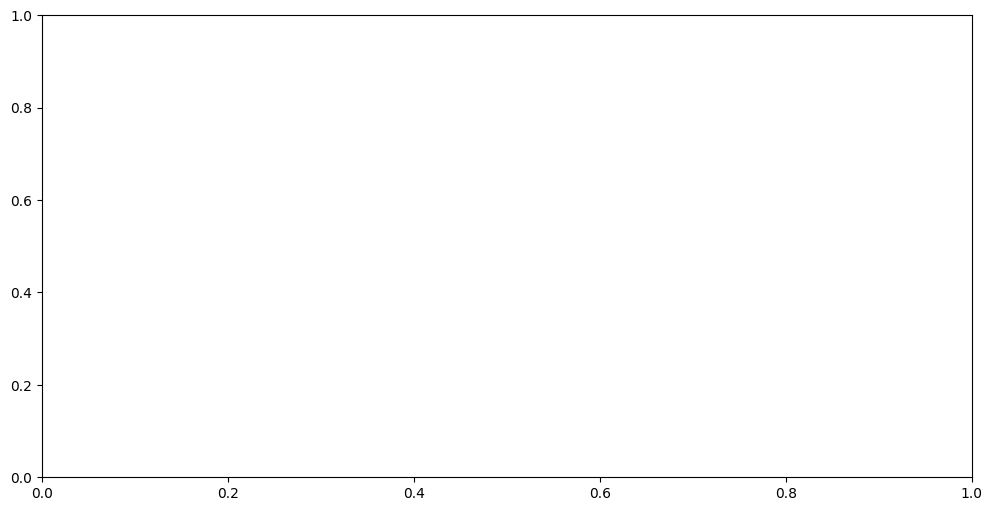

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# View and claim rates by lead-time bucket
print("View and Claim Rates by Lead Time Bin:")
display(lead_time_analysis[['lead_time_bin', 'is_viewed', 'is_claimed']])

plt.figure(figsize=(12, 6))
sns.lineplot(x='lead_time_bin', y='is_viewed', data=lead_time_analysis, label='View Rate', marker='o')
sns.lineplot(x='lead_time_bin', y='is_claimed', data=lead_time_analysis, label='Claim Rate', marker='o')
plt.title('View and Claim Rates by Lead Time')
plt.ylabel('Rate')
plt.xlabel('Lead Time (hours) Bin')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Claim and cancellation rates by pay-band
print("\nClaim and Cancellation Rates by Pay Rate Bin:")
# We need to calculate cancellation rate per pay bin. First, group claimed shifts by pay rate bin
claimed_shifts_by_pay_bin = df[df['is_claimed'] == True].groupby('pay_rate_bin').agg(
    claimed_shifts=('SHIFT_ID', 'count'),
    canceled_shifts=('is_canceled', 'sum')
).reset_index()
claimed_shifts_by_pay_bin['cancellation_rate'] = claimed_shifts_by_pay_bin['canceled_shifts'] / claimed_shifts_by_pay_bin['claimed_shifts']
claimed_shifts_by_pay_bin['cancellation_rate'].fillna(0, inplace=True)

# Merge with pay_rate_analysis to get claim rate per bin
pay_rate_claim_cancel_analysis = pd.merge(pay_rate_analysis, claimed_shifts_by_pay_bin[['pay_rate_bin', 'cancellation_rate']], on='pay_rate_bin', how='left')
pay_rate_claim_cancel_analysis['cancellation_rate'].fillna(0, inplace=True)

display(pay_rate_claim_cancel_analysis[['pay_rate_bin', 'is_claimed', 'cancellation_rate']])

plt.figure(figsize=(10, 6))
sns.lineplot(x='pay_rate_bin', y='is_claimed', data=pay_rate_claim_cancel_analysis, label='Claim Rate', marker='o')
sns.lineplot(x='pay_rate_bin', y='cancellation_rate', data=pay_rate_claim_cancel_analysis, label='Cancellation Rate', marker='o')
plt.title('Claim and Cancellation Rates by Pay Rate Per Hour')
plt.ylabel('Rate')
plt.xlabel('Pay Rate Per Hour Bin')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Engagement heatmaps by hour and weekday
# We need to group by day of week and hour of day to create the heatmap data
engagement_heatmap_data = df.groupby(['day_of_week', 'hour_of_day']).agg(
    view_rate=('is_viewed', 'mean'),
    claim_rate=('is_claimed', 'mean')
).reset_index()

# Pivot the data for heatmap
view_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='view_rate').fillna(0)
claim_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='claim_rate').fillna(0)

# Ensure correct order of days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
view_heatmap_data = view_heatmap_data.reindex(days_order)
claim_heatmap_data = claim_heatmap_data.reindex(days_order)


print("\nView Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(view_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('View Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

print("\nClaim Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(claim_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Claim Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import numpy as np

# Load the data (from b0345abc)
file_path = '/content/Problems we tackle, Shift Offers v3.xlsx'
df = pd.read_excel(file_path)

# Data Cleaning and Preprocessing (from 9bf4a2c7, dabc80a9, a695bff3)
datetime_columns = ['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'CLAIMED_AT', 'DELETED_AT', 'CANCELED_AT']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

df.drop_duplicates(inplace=True)

# Feature Engineering (from 1edc4da6)
df['lead_time_hours'] = (df['SHIFT_START_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['day_of_week'] = df['SHIFT_START_AT'].dt.day_name()
df['hour_of_day'] = df['SHIFT_START_AT'].dt.hour
df['view_time_hours'] = (df['OFFER_VIEWED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['view_time_hours'].fillna(-1, inplace=True)
df['claim_time_hours'] = (df['CLAIMED_AT'] - df['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
df['claim_time_hours'].fillna(-1, inplace=True)
df['claim_from_created_time_hours'] = (df['CLAIMED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['claim_from_created_time_hours'].fillna(-1, inplace=True)
df['pay_rate_per_hour'] = df['PAY_RATE'] / df['DURATION']
df['charge_rate_per_hour'] = df['CHARGE_RATE'] / df['DURATION']

# Analyze shift offer acceptance/rejection (from 90c45f18 and part of 43583f25 and ZMCCeO-17zBy)
df['is_viewed'] = df['OFFER_VIEWED_AT'].notna()
df['is_claimed'] = df['CLAIMED_AT'].notna()
df['is_canceled'] = df['CANCELED_AT'].notna()

# Re-calculate analysis dataframes needed for plotting (from 43583f25 and ZMCCeO-17zBy)
day_of_week_analysis = df.groupby('day_of_week')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

hour_bins = range(0, 28, 4)
df['hour_bin'] = pd.cut(df['hour_of_day'], bins=hour_bins, right=False, include_lowest=True)
hour_of_day_analysis = df.groupby('hour_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

lead_time_bins = [-1] + list(range(0, int(df['lead_time_hours'].max()) + 50, 50))
df['lead_time_bin'] = pd.cut(df['lead_time_hours'], bins=lead_time_bins, right=False, include_lowest=True)
lead_time_analysis = df.groupby('lead_time_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning pay rate
max_finite_pay_rate = df[np.isfinite(df['pay_rate_per_hour'])]['pay_rate_per_hour'].max()
df['pay_rate_per_hour'] = np.where(np.isinf(df['pay_rate_per_hour']), max_finite_pay_rate, df['pay_rate_per_hour'])
pay_rate_bins = [-1] + list(range(0, int(df['pay_rate_per_hour'].max()) + 5, 5))
df['pay_rate_bin'] = pd.cut(df['pay_rate_per_hour'], bins=pay_rate_bins, right=False, include_lowest=True)
pay_rate_analysis = df.groupby('pay_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning charge rate
max_finite_charge_rate = df[np.isfinite(df['charge_rate_per_hour'])]['charge_rate_per_hour'].max()
df['charge_rate_per_hour'] = np.where(np.isinf(df['charge_rate_per_hour']), max_finite_charge_rate, df['charge_rate_per_hour'])
charge_rate_bins = [-1] + list(range(0, int(df['charge_rate_per_hour'].max()) + 5, 5))
df['charge_rate_bin'] = pd.cut(df['charge_rate_per_hour'], bins=charge_rate_bins, right=False, include_lowest=True)
charge_rate_analysis = df.groupby('charge_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

/tmp/ipython-input-11-1664195178.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['view_time_hours'].fillna(-1, inplace=True)
/tmp/ipython-input-11-1664195178.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

View and Claim Rates by Lead Time Bin:


,lead_time_bin,is_viewed,is_claimed
0,"[-1, 0)",1.0,1.000000
1,"[0, 50)",1.0,0.034703
2,"[50, 100)",1.0,0.087925
3,"[100, 150)",1.0,0.084886
4,"[150, 200)",1.0,0.080446
5,"[200, 250)",1.0,0.073202
6,"[250, 300)",1.0,0.077117
7,"[300, 350)",1.0,0.069838
8,"[350, 400)",1.0,0.057402
9,"[400, 450)",1.0,0.051098


TypeError: Invalid object type at position 0

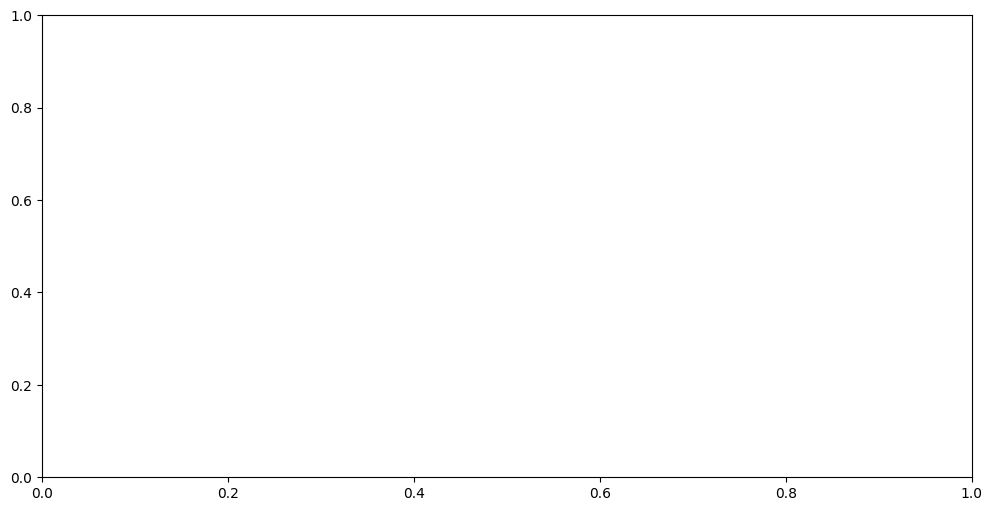

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# View and claim rates by lead-time bucket
print("View and Claim Rates by Lead Time Bin:")
display(lead_time_analysis[['lead_time_bin', 'is_viewed', 'is_claimed']])

plt.figure(figsize=(12, 6))
sns.lineplot(x='lead_time_bin', y='is_viewed', data=lead_time_analysis, label='View Rate', marker='o')
sns.lineplot(x='lead_time_bin', y='is_claimed', data=lead_time_analysis, label='Claim Rate', marker='o')
plt.title('View and Claim Rates by Lead Time')
plt.ylabel('Rate')
plt.xlabel('Lead Time (hours) Bin')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Claim and cancellation rates by pay-band
print("\nClaim and Cancellation Rates by Pay Rate Bin:")
# We need to calculate cancellation rate per pay bin. First, group claimed shifts by pay rate bin
claimed_shifts_by_pay_bin = df[df['is_claimed'] == True].groupby('pay_rate_bin').agg(
    claimed_shifts=('SHIFT_ID', 'count'),
    canceled_shifts=('is_canceled', 'sum')
).reset_index()
claimed_shifts_by_pay_bin['cancellation_rate'] = claimed_shifts_by_pay_bin['canceled_shifts'] / claimed_shifts_by_pay_bin['claimed_shifts']
claimed_shifts_by_pay_bin['cancellation_rate'].fillna(0, inplace=True)

# Merge with pay_rate_analysis to get claim rate per bin
pay_rate_claim_cancel_analysis = pd.merge(pay_rate_analysis, claimed_shifts_by_pay_bin[['pay_rate_bin', 'cancellation_rate']], on='pay_rate_bin', how='left')
pay_rate_claim_cancel_analysis['cancellation_rate'].fillna(0, inplace=True)

display(pay_rate_claim_cancel_analysis[['pay_rate_bin', 'is_claimed', 'cancellation_rate']])

plt.figure(figsize=(10, 6))
sns.lineplot(x='pay_rate_bin', y='is_claimed', data=pay_rate_claim_cancel_analysis, label='Claim Rate', marker='o')
sns.lineplot(x='pay_rate_bin', y='cancellation_rate', data=pay_rate_claim_cancel_analysis, label='Cancellation Rate', marker='o')
plt.title('Claim and Cancellation Rates by Pay Rate Per Hour')
plt.ylabel('Rate')
plt.xlabel('Pay Rate Per Hour Bin')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Engagement heatmaps by hour and weekday
# We need to group by day of week and hour of day to create the heatmap data
engagement_heatmap_data = df.groupby(['day_of_week', 'hour_of_day']).agg(
    view_rate=('is_viewed', 'mean'),
    claim_rate=('is_claimed', 'mean')
).reset_index()

# Pivot the data for heatmap
view_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='view_rate').fillna(0)
claim_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='claim_rate').fillna(0)

# Ensure correct order of days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
view_heatmap_data = view_heatmap_data.reindex(days_order)
claim_heatmap_data = claim_heatmap_data.reindex(days_order)


print("\nView Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(view_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('View Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

print("\nClaim Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(claim_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Claim Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = '/content/Problems we tackle, Shift Offers v3.xlsx'
df = pd.read_excel(file_path)

# Data Cleaning and Preprocessing
datetime_columns = ['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'CLAIMED_AT', 'DELETED_AT', 'CANCELED_AT']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

df.drop_duplicates(inplace=True)

# Feature Engineering
df['lead_time_hours'] = (df['SHIFT_START_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['day_of_week'] = df['SHIFT_START_AT'].dt.day_name()
df['hour_of_day'] = df['SHIFT_START_AT'].dt.hour
df['view_time_hours'] = (df['OFFER_VIEWED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['view_time_hours'].fillna(-1, inplace=True)
df['claim_time_hours'] = (df['CLAIMED_AT'] - df['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
df['claim_time_hours'].fillna(-1, inplace=True)
df['claim_from_created_time_hours'] = (df['CLAIMED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['claim_from_created_time_hours'].fillna(-1, inplace=True)
df['pay_rate_per_hour'] = df['PAY_RATE'] / df['DURATION']
df['charge_rate_per_hour'] = df['CHARGE_RATE'] / df['DURATION']

# Analyze shift offer acceptance/rejection and prepare data for plotting
df['is_viewed'] = df['OFFER_VIEWED_AT'].notna()
df['is_claimed'] = df['CLAIMED_AT'].notna()
df['is_canceled'] = df['CANCELED_AT'].notna()

day_of_week_analysis = df.groupby('day_of_week')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

hour_bins = range(0, 28, 4)
df['hour_bin'] = pd.cut(df['hour_of_day'], bins=hour_bins, right=False, include_lowest=True)
hour_of_day_analysis = df.groupby('hour_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

lead_time_bins = [-1] + list(range(0, int(df['lead_time_hours'].max()) + 50, 50))
df['lead_time_bin'] = pd.cut(df['lead_time_hours'], bins=lead_time_bins, right=False, include_lowest=True)
lead_time_analysis = df.groupby('lead_time_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning pay rate
max_finite_pay_rate = df[np.isfinite(df['pay_rate_per_hour'])]['pay_rate_per_hour'].max()
df['pay_rate_per_hour'] = np.where(np.isinf(df['pay_rate_per_hour']), max_finite_pay_rate, df['pay_rate_per_hour'])
pay_rate_bins = [-1] + list(range(0, int(df['pay_rate_per_hour'].max()) + 5, 5))
df['pay_rate_bin'] = pd.cut(df['pay_rate_per_hour'], bins=pay_rate_bins, right=False, include_lowest=True)
pay_rate_analysis = df.groupby('pay_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning charge rate
max_finite_charge_rate = df[np.isfinite(df['charge_rate_per_hour'])]['charge_rate_per_hour'].max()
df['charge_rate_per_hour'] = np.where(np.isinf(df['charge_rate_per_hour']), max_finite_charge_rate, df['charge_rate_per_hour'])
charge_rate_bins = [-1] + list(range(0, int(df['charge_rate_per_hour'].max()) + 5, 5))
df['charge_rate_bin'] = pd.cut(df['charge_rate_per_hour'], bins=charge_rate_bins, right=False, include_lowest=True)
charge_rate_analysis = df.groupby('charge_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

/tmp/ipython-input-16-3160749937.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['view_time_hours'].fillna(-1, inplace=True)
/tmp/ipython-input-16-3160749937.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

View and Claim Rates by Lead Time Bin:


,lead_time_bin,is_viewed,is_claimed
0,"[-1, 0)",1.0,1.000000
1,"[0, 50)",1.0,0.034703
2,"[50, 100)",1.0,0.087925
3,"[100, 150)",1.0,0.084886
4,"[150, 200)",1.0,0.080446
5,"[200, 250)",1.0,0.073202
6,"[250, 300)",1.0,0.077117
7,"[300, 350)",1.0,0.069838
8,"[350, 400)",1.0,0.057402
9,"[400, 450)",1.0,0.051098


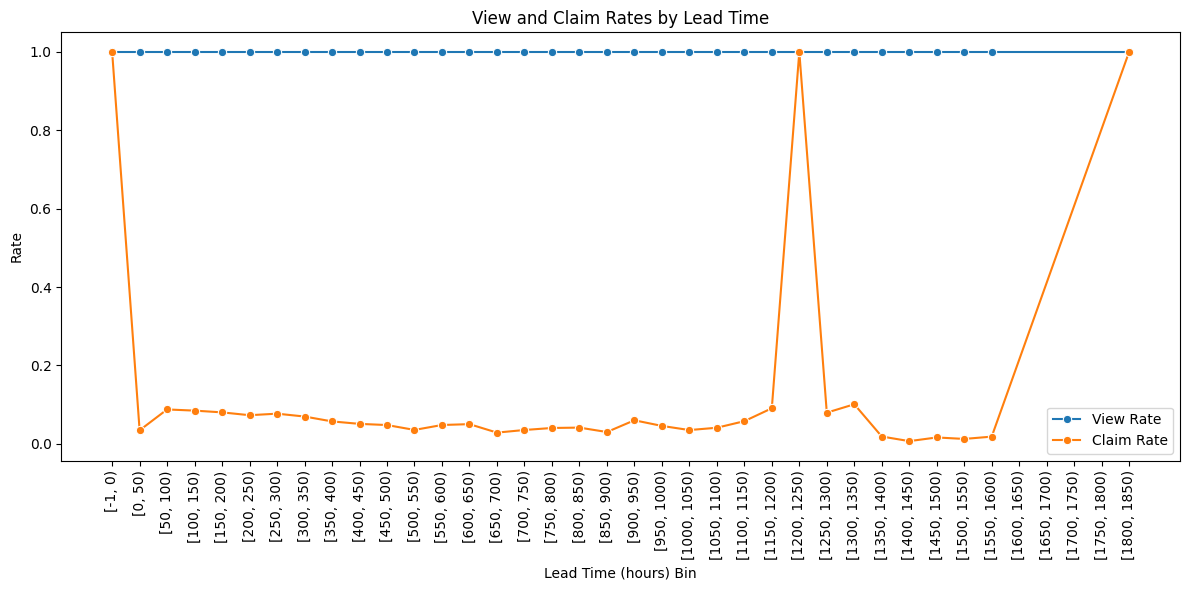


Claim and Cancellation Rates by Pay Rate Bin:


/tmp/ipython-input-18-301297078.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  claimed_shifts_by_pay_bin = df[df['is_claimed'] == True].groupby('pay_rate_bin').agg(
/tmp/ipython-input-18-301297078.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  claimed_shifts_by_pay_bin['cancellation_rate'].fillna(0, inplace=True)
/tmp/ipython-

,pay_rate_bin,is_claimed,cancellation_rate
0,"[-1, 0)",NaN,0.000000
1,"[0, 5)",0.048016,0.025216
2,"[5, 10)",0.093645,0.008977
3,"[10, 15)",0.070968,0.090909
4,"[15, 20)",1.000000,0.000000
5,"[20, 25)",0.041096,0.000000


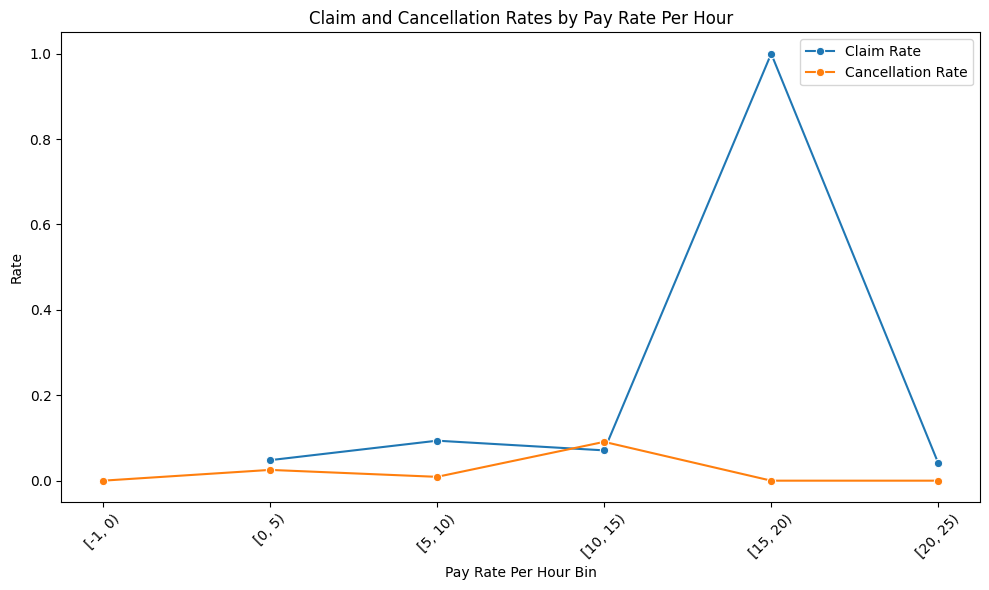


View Rate Heatmap by Day of Week and Hour of Day:


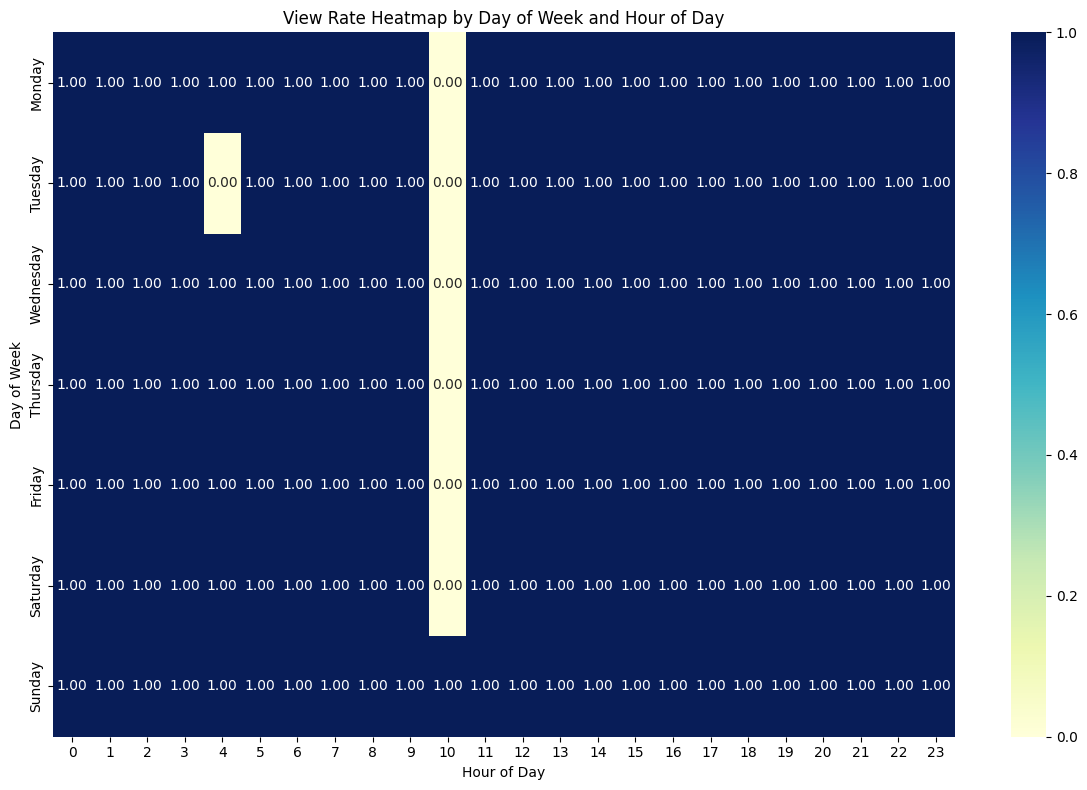


Claim Rate Heatmap by Day of Week and Hour of Day:


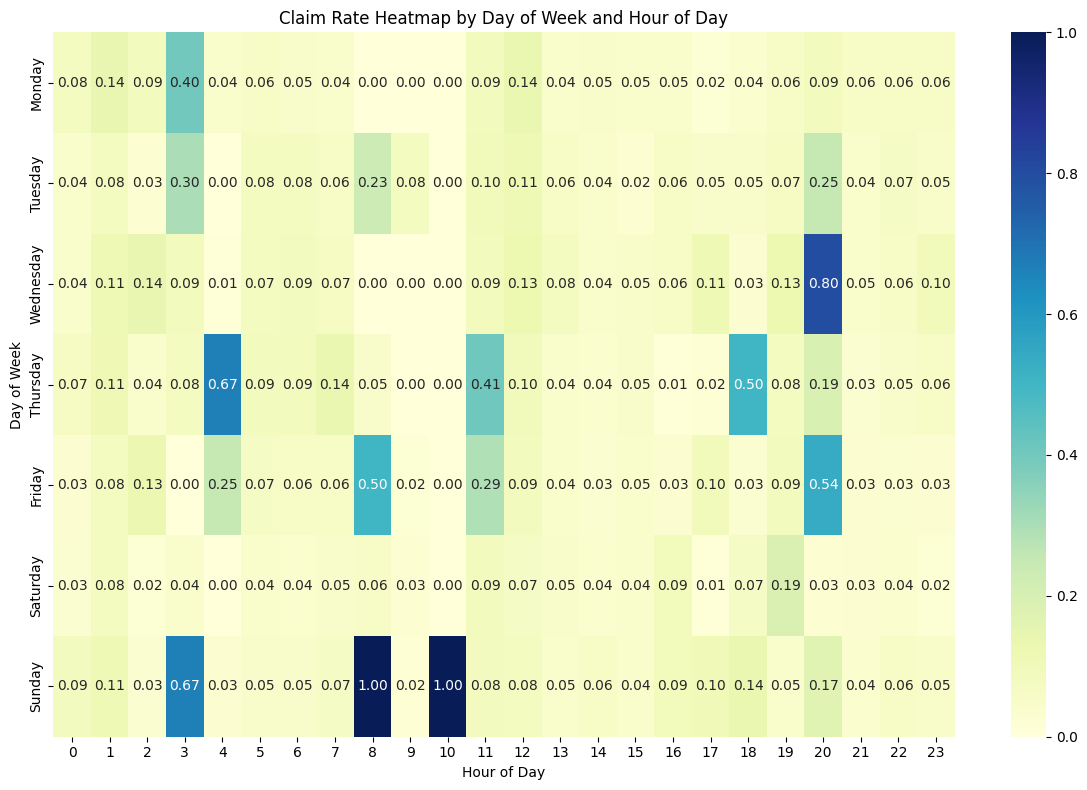

In [18]:
# View and claim rates by lead-time bucket
print("View and Claim Rates by Lead Time Bin:")
display(lead_time_analysis[['lead_time_bin', 'is_viewed', 'is_claimed']])

# Convert lead_time_bin to string for plotting
lead_time_analysis['lead_time_bin_str'] = lead_time_analysis['lead_time_bin'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x='lead_time_bin_str', y='is_viewed', data=lead_time_analysis, label='View Rate', marker='o')
sns.lineplot(x='lead_time_bin_str', y='is_claimed', data=lead_time_analysis, label='Claim Rate', marker='o')
plt.title('View and Claim Rates by Lead Time')
plt.ylabel('Rate')
plt.xlabel('Lead Time (hours) Bin')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Claim and cancellation rates by pay-band
print("\nClaim and Cancellation Rates by Pay Rate Bin:")
# We need to calculate cancellation rate per pay bin. First, group claimed shifts by pay rate bin
claimed_shifts_by_pay_bin = df[df['is_claimed'] == True].groupby('pay_rate_bin').agg(
    claimed_shifts=('SHIFT_ID', 'count'),
    canceled_shifts=('is_canceled', 'sum')
).reset_index()
claimed_shifts_by_pay_bin['cancellation_rate'] = claimed_shifts_by_pay_bin['canceled_shifts'] / claimed_shifts_by_pay_bin['claimed_shifts']
claimed_shifts_by_pay_bin['cancellation_rate'].fillna(0, inplace=True)

# Merge with pay_rate_analysis to get claim rate per bin
pay_rate_claim_cancel_analysis = pd.merge(pay_rate_analysis, claimed_shifts_by_pay_bin[['pay_rate_bin', 'cancellation_rate']], on='pay_rate_bin', how='left')
pay_rate_claim_cancel_analysis['cancellation_rate'].fillna(0, inplace=True)

display(pay_rate_claim_cancel_analysis[['pay_rate_bin', 'is_claimed', 'cancellation_rate']])

# Convert pay_rate_bin to string for plotting
pay_rate_claim_cancel_analysis['pay_rate_bin_str'] = pay_rate_claim_cancel_analysis['pay_rate_bin'].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(x='pay_rate_bin_str', y='is_claimed', data=pay_rate_claim_cancel_analysis, label='Claim Rate', marker='o')
sns.lineplot(x='pay_rate_bin_str', y='cancellation_rate', data=pay_rate_claim_cancel_analysis, label='Cancellation Rate', marker='o')
plt.title('Claim and Cancellation Rates by Pay Rate Per Hour')
plt.ylabel('Rate')
plt.xlabel('Pay Rate Per Hour Bin')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Engagement heatmaps by hour and weekday
# We need to group by day of week and hour of day to create the heatmap data
engagement_heatmap_data = df.groupby(['day_of_week', 'hour_of_day']).agg(
    view_rate=('is_viewed', 'mean'),
    claim_rate=('is_claimed', 'mean')
).reset_index()

# Pivot the data for heatmap
view_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='view_rate').fillna(0)
claim_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='claim_rate').fillna(0)

# Ensure correct order of days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
view_heatmap_data = view_heatmap_data.reindex(days_order)
claim_heatmap_data = claim_heatmap_data.reindex(days_order)


print("\nView Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(view_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('View Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

print("\nClaim Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(claim_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Claim Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
import numpy as np

# Load the data
file_path = '/content/Problems we tackle, Shift Offers v3.xlsx'
df = pd.read_excel(file_path)

# Data Cleaning and Preprocessing
datetime_columns = ['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'CLAIMED_AT', 'DELETED_AT', 'CANCELED_AT']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

df.drop_duplicates(inplace=True)

# Feature Engineering
df['lead_time_hours'] = (df['SHIFT_START_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['day_of_week'] = df['SHIFT_START_AT'].dt.day_name()
df['hour_of_day'] = df['SHIFT_START_AT'].dt.hour
df['view_time_hours'] = (df['OFFER_VIEWED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['view_time_hours'].fillna(-1, inplace=True)
df['claim_time_hours'] = (df['CLAIMED_AT'] - df['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
df['claim_time_hours'].fillna(-1, inplace=True)
df['claim_from_created_time_hours'] = (df['CLAIMED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['claim_from_created_time_hours'].fillna(-1, inplace=True)
df['pay_rate_per_hour'] = df['PAY_RATE'] / df['DURATION']
df['charge_rate_per_hour'] = df['CHARGE_RATE'] / df['DURATION']

# Analyze shift offer acceptance/rejection and prepare data for plotting
df['is_viewed'] = df['OFFER_VIEWED_AT'].notna()
df['is_claimed'] = df['CLAIMED_AT'].notna()
df['is_canceled'] = df['CANCELED_AT'].notna()

day_of_week_analysis = df.groupby('day_of_week')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

hour_bins = range(0, 28, 4)
df['hour_bin'] = pd.cut(df['hour_of_day'], bins=hour_bins, right=False, include_lowest=True)
hour_of_day_analysis = df.groupby('hour_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

lead_time_bins = [-1] + list(range(0, int(df['lead_time_hours'].max()) + 50, 50))
df['lead_time_bin'] = pd.cut(df['lead_time_hours'], bins=lead_time_bins, right=False, include_lowest=True)
lead_time_analysis = df.groupby('lead_time_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning pay rate
max_finite_pay_rate = df[np.isfinite(df['pay_rate_per_hour'])]['pay_rate_per_hour'].max()
df['pay_rate_per_hour'] = np.where(np.isinf(df['pay_rate_per_hour']), max_finite_pay_rate, df['pay_rate_per_hour'])
pay_rate_bins = [-1] + list(range(0, int(df['pay_rate_per_hour'].max()) + 5, 5))
df['pay_rate_bin'] = pd.cut(df['pay_rate_per_hour'], bins=pay_rate_bins, right=False, include_lowest=True)
pay_rate_analysis = df.groupby('pay_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning charge rate
max_finite_charge_rate = df[np.isfinite(df['charge_rate_per_hour'])]['charge_rate_per_hour'].max()
df['charge_rate_per_hour'] = np.where(np.isinf(df['charge_rate_per_hour']), max_finite_charge_rate, df['charge_rate_per_hour'])
charge_rate_bins = [-1] + list(range(0, int(df['charge_rate_per_hour'].max()) + 5, 5))
df['charge_rate_bin'] = pd.cut(df['charge_rate_per_hour'], bins=charge_rate_bins, right=False, include_lowest=True)
charge_rate_analysis = df.groupby('charge_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

/tmp/ipython-input-3-1324187734.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['view_time_hours'].fillna(-1, inplace=True)
/tmp/ipython-input-3-1324187734.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

View and Claim Rates by Lead Time Bin:


,lead_time_bin,is_viewed,is_claimed
0,"[-1, 0)",1.0,1.000000
1,"[0, 50)",1.0,0.034703
2,"[50, 100)",1.0,0.087925
3,"[100, 150)",1.0,0.084886
4,"[150, 200)",1.0,0.080446
5,"[200, 250)",1.0,0.073202
6,"[250, 300)",1.0,0.077117
7,"[300, 350)",1.0,0.069838
8,"[350, 400)",1.0,0.057402
9,"[400, 450)",1.0,0.051098


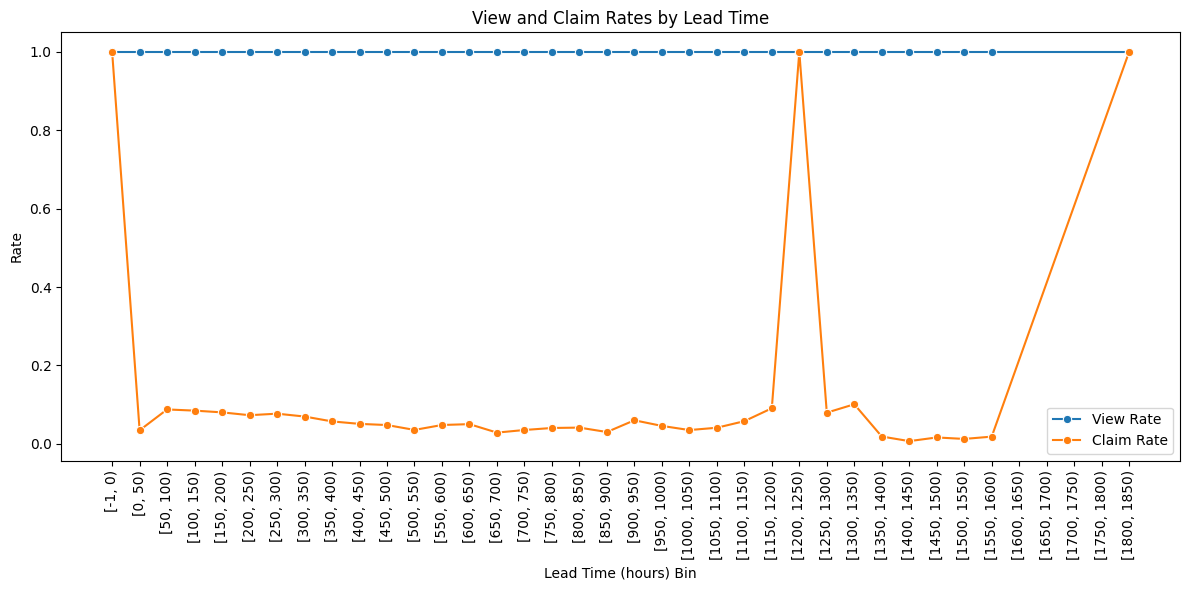


Claim and Cancellation Rates by Pay Rate Bin:


/tmp/ipython-input-4-1027557206.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  claimed_shifts_by_pay_bin = df[df['is_claimed'] == True].groupby('pay_rate_bin').agg(
/tmp/ipython-input-4-1027557206.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  claimed_shifts_by_pay_bin['cancellation_rate'].fillna(0, inplace=True)
/tmp/ipython-

,pay_rate_bin,is_claimed,cancellation_rate
0,"[-1, 0)",NaN,0.000000
1,"[0, 5)",0.048016,0.025216
2,"[5, 10)",0.093645,0.008977
3,"[10, 15)",0.070968,0.090909
4,"[15, 20)",1.000000,0.000000
5,"[20, 25)",0.041096,0.000000


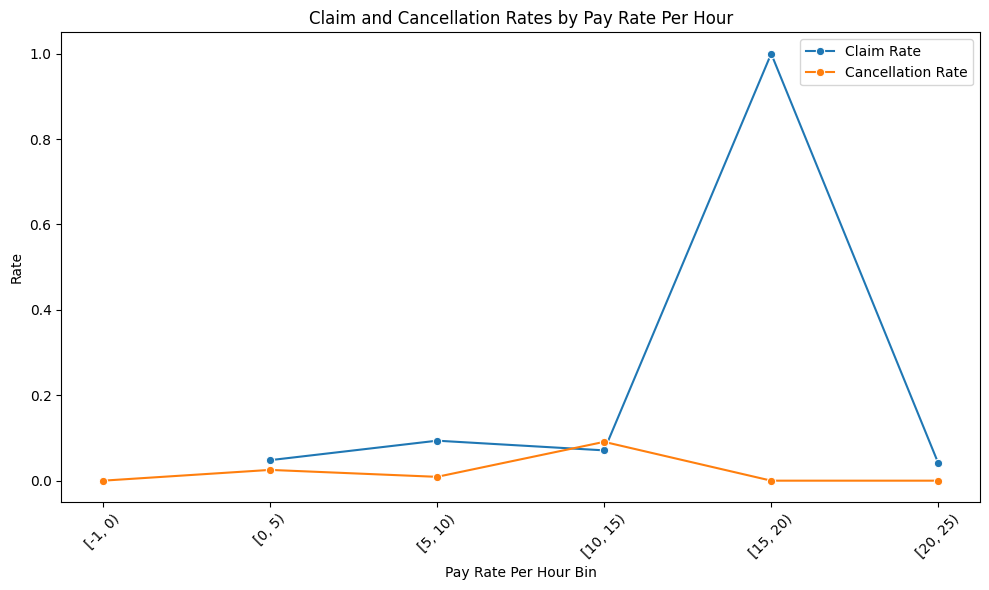


View Rate Heatmap by Day of Week and Hour of Day:


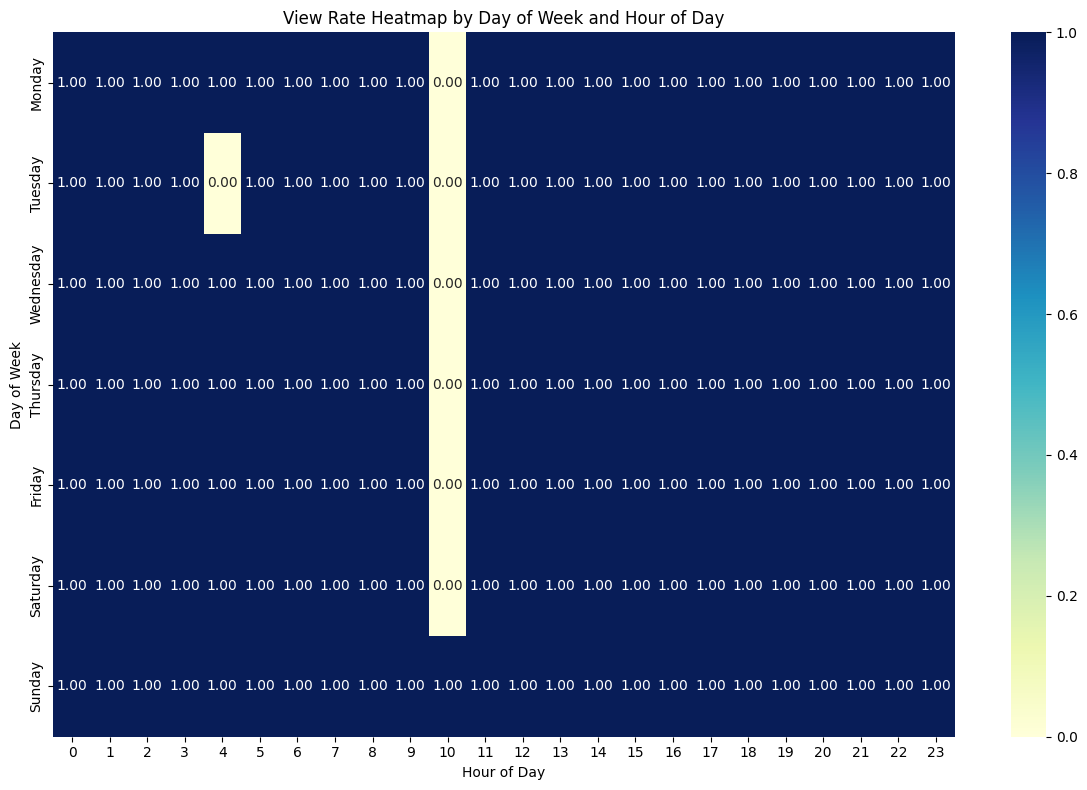


Claim Rate Heatmap by Day of Week and Hour of Day:


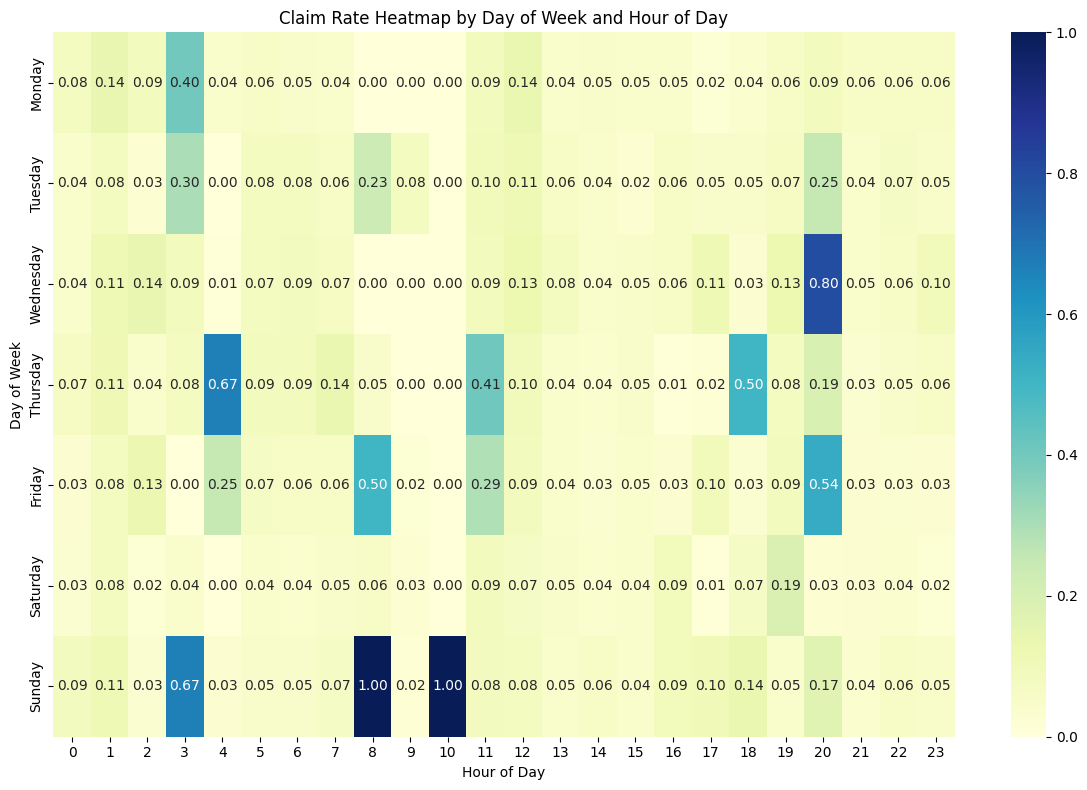

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# View and claim rates by lead-time bucket
print("View and Claim Rates by Lead Time Bin:")
display(lead_time_analysis[['lead_time_bin', 'is_viewed', 'is_claimed']])

# Convert lead_time_bin to string for plotting
lead_time_analysis['lead_time_bin_str'] = lead_time_analysis['lead_time_bin'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x='lead_time_bin_str', y='is_viewed', data=lead_time_analysis, label='View Rate', marker='o')
sns.lineplot(x='lead_time_bin_str', y='is_claimed', data=lead_time_analysis, label='Claim Rate', marker='o')
plt.title('View and Claim Rates by Lead Time')
plt.ylabel('Rate')
plt.xlabel('Lead Time (hours) Bin')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Claim and cancellation rates by pay-band
print("\nClaim and Cancellation Rates by Pay Rate Bin:")
# We need to calculate cancellation rate per pay bin. First, group claimed shifts by pay rate bin
claimed_shifts_by_pay_bin = df[df['is_claimed'] == True].groupby('pay_rate_bin').agg(
    claimed_shifts=('SHIFT_ID', 'count'),
    canceled_shifts=('is_canceled', 'sum')
).reset_index()
claimed_shifts_by_pay_bin['cancellation_rate'] = claimed_shifts_by_pay_bin['canceled_shifts'] / claimed_shifts_by_pay_bin['claimed_shifts']
claimed_shifts_by_pay_bin['cancellation_rate'].fillna(0, inplace=True)

# Merge with pay_rate_analysis to get claim rate per bin
pay_rate_claim_cancel_analysis = pd.merge(pay_rate_analysis, claimed_shifts_by_pay_bin[['pay_rate_bin', 'cancellation_rate']], on='pay_rate_bin', how='left')
pay_rate_claim_cancel_analysis['cancellation_rate'].fillna(0, inplace=True)

display(pay_rate_claim_cancel_analysis[['pay_rate_bin', 'is_claimed', 'cancellation_rate']])

# Convert pay_rate_bin to string for plotting
pay_rate_claim_cancel_analysis['pay_rate_bin_str'] = pay_rate_claim_cancel_analysis['pay_rate_bin'].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(x='pay_rate_bin_str', y='is_claimed', data=pay_rate_claim_cancel_analysis, label='Claim Rate', marker='o')
sns.lineplot(x='pay_rate_bin_str', y='cancellation_rate', data=pay_rate_claim_cancel_analysis, label='Cancellation Rate', marker='o')
plt.title('Claim and Cancellation Rates by Pay Rate Per Hour')
plt.ylabel('Rate')
plt.xlabel('Pay Rate Per Hour Bin')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Engagement heatmaps by hour and weekday
# We need to group by day of week and hour of day to create the heatmap data
engagement_heatmap_data = df.groupby(['day_of_week', 'hour_of_day']).agg(
    view_rate=('is_viewed', 'mean'),
    claim_rate=('is_claimed', 'mean')
).reset_index()

# Pivot the data for heatmap
view_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='view_rate').fillna(0)
claim_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='claim_rate').fillna(0)

# Ensure correct order of days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
view_heatmap_data = view_heatmap_data.reindex(days_order)
claim_heatmap_data = claim_heatmap_data.reindex(days_order)


print("\nView Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(view_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('View Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

print("\nClaim Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(claim_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Claim Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = '/content/Problems we tackle, Shift Offers v3.xlsx'
df = pd.read_excel(file_path)

# Data Cleaning and Preprocessing
datetime_columns = ['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'CLAIMED_AT', 'DELETED_AT', 'CANCELED_AT']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

df.drop_duplicates(inplace=True)

# Feature Engineering
df['lead_time_hours'] = (df['SHIFT_START_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['day_of_week'] = df['SHIFT_START_AT'].dt.day_name()
df['hour_of_day'] = df['SHIFT_START_AT'].dt.hour
df['view_time_hours'] = (df['OFFER_VIEWED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['view_time_hours'].fillna(-1, inplace=True)
df['claim_time_hours'] = (df['CLAIMED_AT'] - df['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
df['claim_time_hours'].fillna(-1, inplace=True)
df['claim_from_created_time_hours'] = (df['CLAIMED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['claim_from_created_time_hours'].fillna(-1, inplace=True)
df['pay_rate_per_hour'] = df['PAY_RATE'] / df['DURATION']
df['charge_rate_per_hour'] = df['CHARGE_RATE'] / df['DURATION']

# Analyze shift offer acceptance/rejection and prepare data for plotting
df['is_viewed'] = df['OFFER_VIEWED_AT'].notna()
df['is_claimed'] = df['CLAIMED_AT'].notna()
df['is_canceled'] = df['CANCELED_AT'].notna()

day_of_week_analysis = df.groupby('day_of_week')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

hour_bins = range(0, 28, 4)
df['hour_bin'] = pd.cut(df['hour_of_day'], bins=hour_bins, right=False, include_lowest=True)
hour_of_day_analysis = df.groupby('hour_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

lead_time_bins = [-1] + list(range(0, int(df['lead_time_hours'].max()) + 50, 50))
df['lead_time_bin'] = pd.cut(df['lead_time_hours'], bins=lead_time_bins, right=False, include_lowest=True)
lead_time_analysis = df.groupby('lead_time_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning pay rate
max_finite_pay_rate = df[np.isfinite(df['pay_rate_per_hour'])]['pay_rate_per_hour'].max()
df['pay_rate_per_hour'] = np.where(np.isinf(df['pay_rate_per_hour']), max_finite_pay_rate, df['pay_rate_per_hour'])
pay_rate_bins = [-1] + list(range(0, int(df['pay_rate_per_hour'].max()) + 5, 5))
df['pay_rate_bin'] = pd.cut(df['pay_rate_per_hour'], bins=pay_rate_bins, right=False, include_lowest=True)
pay_rate_analysis = df.groupby('pay_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning charge rate
max_finite_charge_rate = df[np.isfinite(df['charge_rate_per_hour'])]['charge_rate_per_hour'].max()
df['charge_rate_per_hour'] = np.where(np.isinf(df['charge_rate_per_hour']), max_finite_charge_rate, df['charge_rate_per_hour'])
charge_rate_bins = [-1] + list(range(0, int(df['charge_rate_per_hour'].max()) + 5, 5))
df['charge_rate_bin'] = pd.cut(df['charge_rate_per_hour'], bins=charge_rate_bins, right=False, include_lowest=True)
charge_rate_analysis = df.groupby('charge_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

View and Claim Rates by Lead Time Bin:


,lead_time_bin,is_viewed,is_claimed
0,"[-1, 0)",1.0,1.000000
1,"[0, 50)",1.0,0.034703
2,"[50, 100)",1.0,0.087925
3,"[100, 150)",1.0,0.084886
4,"[150, 200)",1.0,0.080446
5,"[200, 250)",1.0,0.073202
6,"[250, 300)",1.0,0.077117
7,"[300, 350)",1.0,0.069838
8,"[350, 400)",1.0,0.057402
9,"[400, 450)",1.0,0.051098


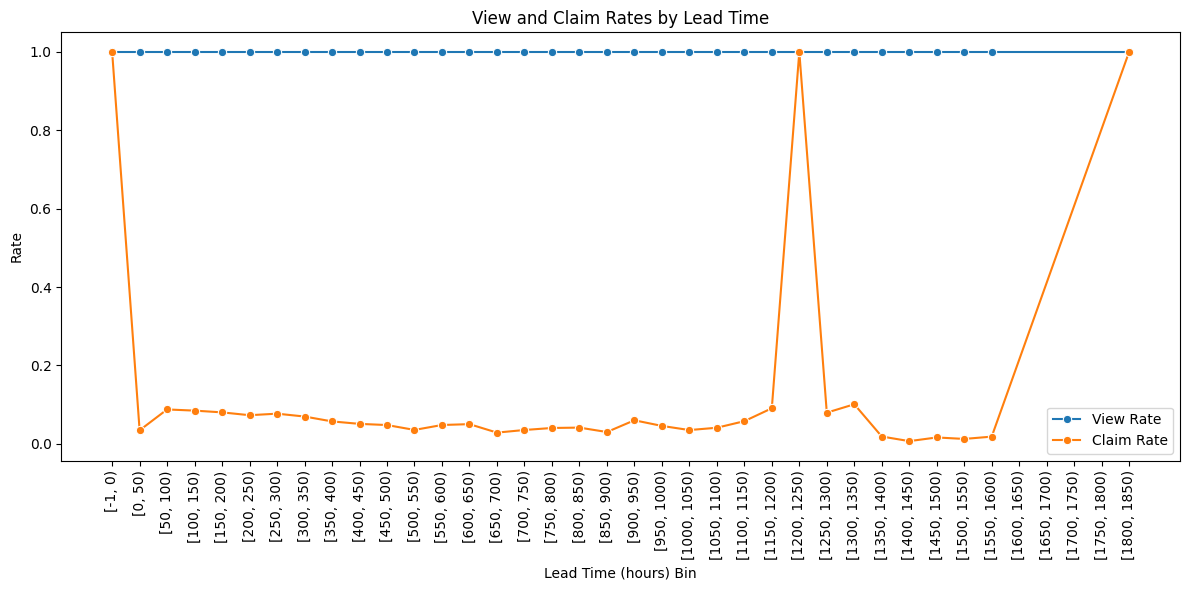


Claim and Cancellation Rates by Pay Rate Bin:


/tmp/ipython-input-6-301297078.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  claimed_shifts_by_pay_bin = df[df['is_claimed'] == True].groupby('pay_rate_bin').agg(
/tmp/ipython-input-6-301297078.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  claimed_shifts_by_pay_bin['cancellation_rate'].fillna(0, inplace=True)
/tmp/ipython-in

,pay_rate_bin,is_claimed,cancellation_rate
0,"[-1, 0)",NaN,0.000000
1,"[0, 5)",0.048016,0.025216
2,"[5, 10)",0.093645,0.008977
3,"[10, 15)",0.070968,0.090909
4,"[15, 20)",1.000000,0.000000
5,"[20, 25)",0.041096,0.000000


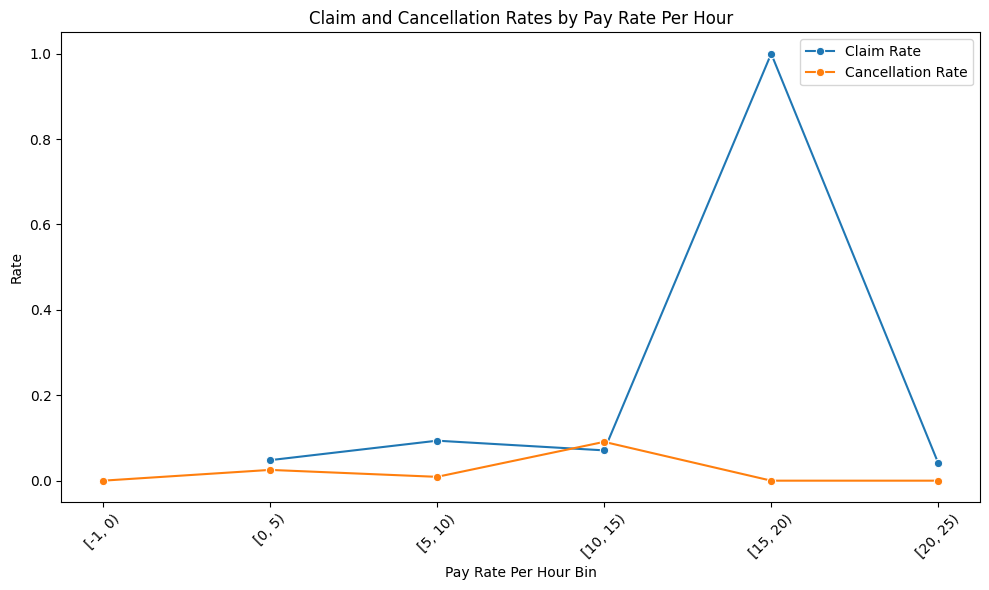


View Rate Heatmap by Day of Week and Hour of Day:


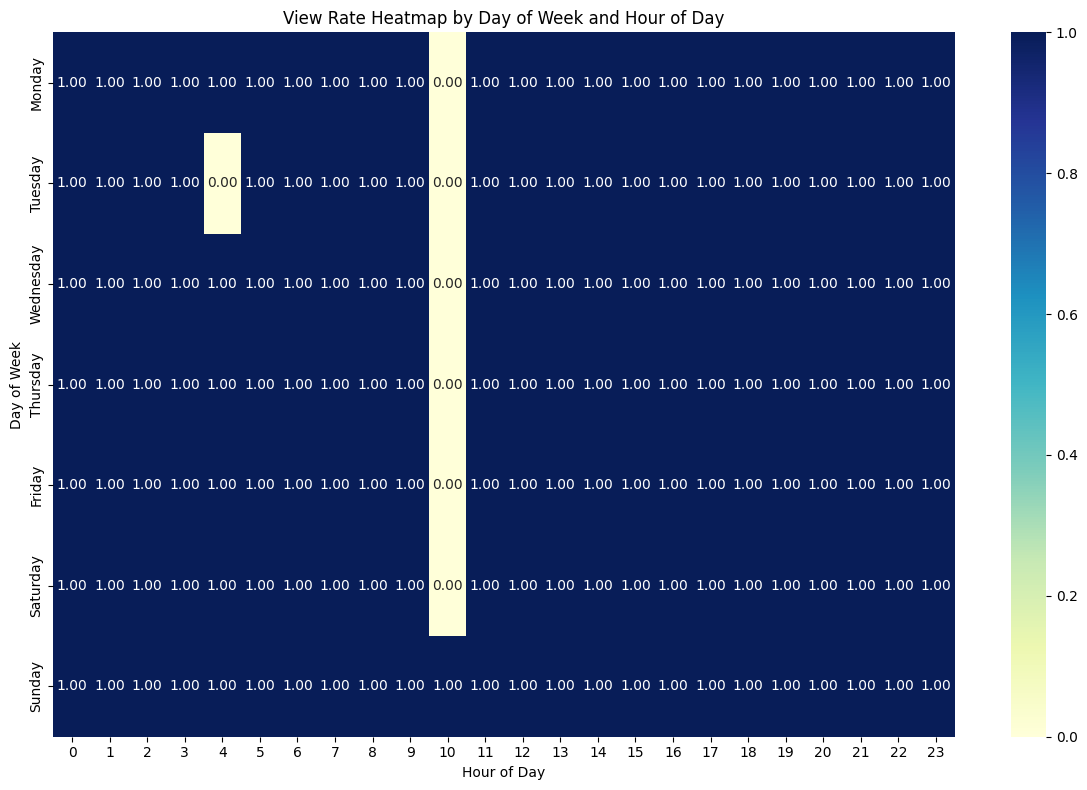


Claim Rate Heatmap by Day of Week and Hour of Day:


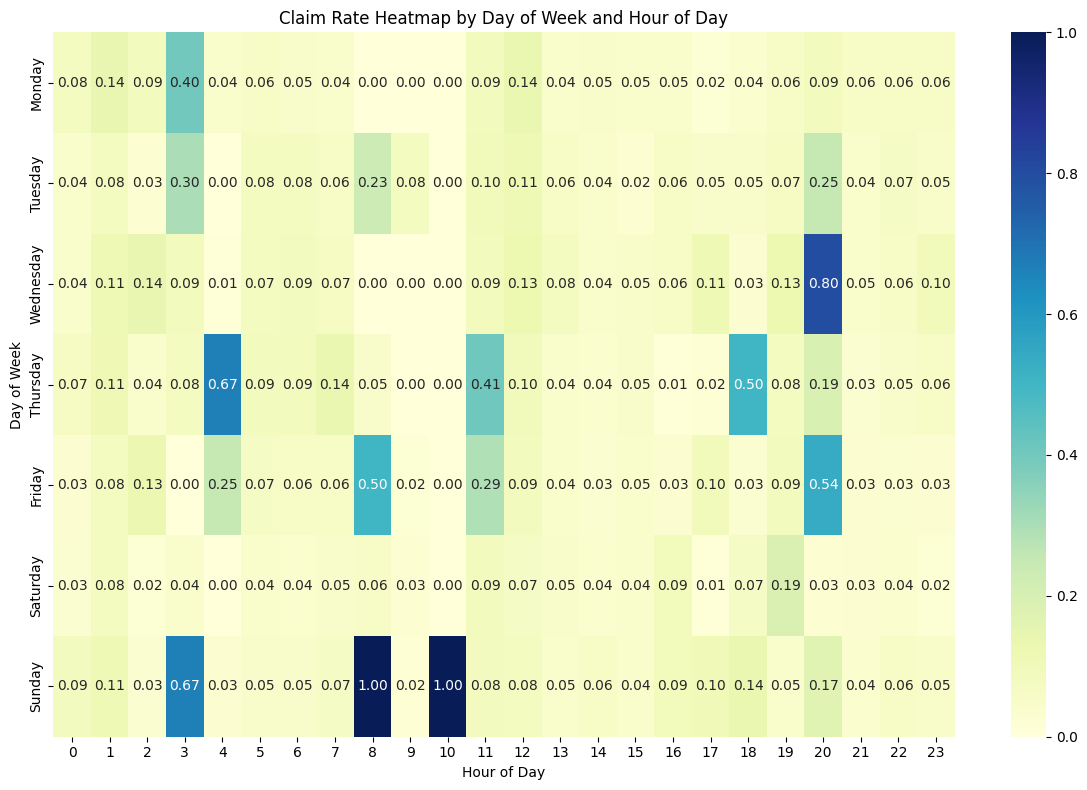

In [6]:
# View and claim rates by lead-time bucket
print("View and Claim Rates by Lead Time Bin:")
display(lead_time_analysis[['lead_time_bin', 'is_viewed', 'is_claimed']])

# Convert lead_time_bin to string for plotting
lead_time_analysis['lead_time_bin_str'] = lead_time_analysis['lead_time_bin'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x='lead_time_bin_str', y='is_viewed', data=lead_time_analysis, label='View Rate', marker='o')
sns.lineplot(x='lead_time_bin_str', y='is_claimed', data=lead_time_analysis, label='Claim Rate', marker='o')
plt.title('View and Claim Rates by Lead Time')
plt.ylabel('Rate')
plt.xlabel('Lead Time (hours) Bin')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Claim and cancellation rates by pay-band
print("\nClaim and Cancellation Rates by Pay Rate Bin:")
# We need to calculate cancellation rate per pay bin. First, group claimed shifts by pay rate bin
claimed_shifts_by_pay_bin = df[df['is_claimed'] == True].groupby('pay_rate_bin').agg(
    claimed_shifts=('SHIFT_ID', 'count'),
    canceled_shifts=('is_canceled', 'sum')
).reset_index()
claimed_shifts_by_pay_bin['cancellation_rate'] = claimed_shifts_by_pay_bin['canceled_shifts'] / claimed_shifts_by_pay_bin['claimed_shifts']
claimed_shifts_by_pay_bin['cancellation_rate'].fillna(0, inplace=True)

# Merge with pay_rate_analysis to get claim rate per bin
pay_rate_claim_cancel_analysis = pd.merge(pay_rate_analysis, claimed_shifts_by_pay_bin[['pay_rate_bin', 'cancellation_rate']], on='pay_rate_bin', how='left')
pay_rate_claim_cancel_analysis['cancellation_rate'].fillna(0, inplace=True)

display(pay_rate_claim_cancel_analysis[['pay_rate_bin', 'is_claimed', 'cancellation_rate']])

# Convert pay_rate_bin to string for plotting
pay_rate_claim_cancel_analysis['pay_rate_bin_str'] = pay_rate_claim_cancel_analysis['pay_rate_bin'].astype(str)

plt.figure(figsize=(10, 6))
sns.lineplot(x='pay_rate_bin_str', y='is_claimed', data=pay_rate_claim_cancel_analysis, label='Claim Rate', marker='o')
sns.lineplot(x='pay_rate_bin_str', y='cancellation_rate', data=pay_rate_claim_cancel_analysis, label='Cancellation Rate', marker='o')
plt.title('Claim and Cancellation Rates by Pay Rate Per Hour')
plt.ylabel('Rate')
plt.xlabel('Pay Rate Per Hour Bin')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Engagement heatmaps by hour and weekday
# We need to group by day of week and hour of day to create the heatmap data
engagement_heatmap_data = df.groupby(['day_of_week', 'hour_of_day']).agg(
    view_rate=('is_viewed', 'mean'),
    claim_rate=('is_claimed', 'mean')
).reset_index()

# Pivot the data for heatmap
view_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='view_rate').fillna(0)
claim_heatmap_data = engagement_heatmap_data.pivot_table(index='day_of_week', columns='hour_of_day', values='claim_rate').fillna(0)

# Ensure correct order of days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
view_heatmap_data = view_heatmap_data.reindex(days_order)
claim_heatmap_data = claim_heatmap_data.reindex(days_order)


print("\nView Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(view_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('View Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

print("\nClaim Rate Heatmap by Day of Week and Hour of Day:")
plt.figure(figsize=(12, 8))
sns.heatmap(claim_heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Claim Rate Heatmap by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

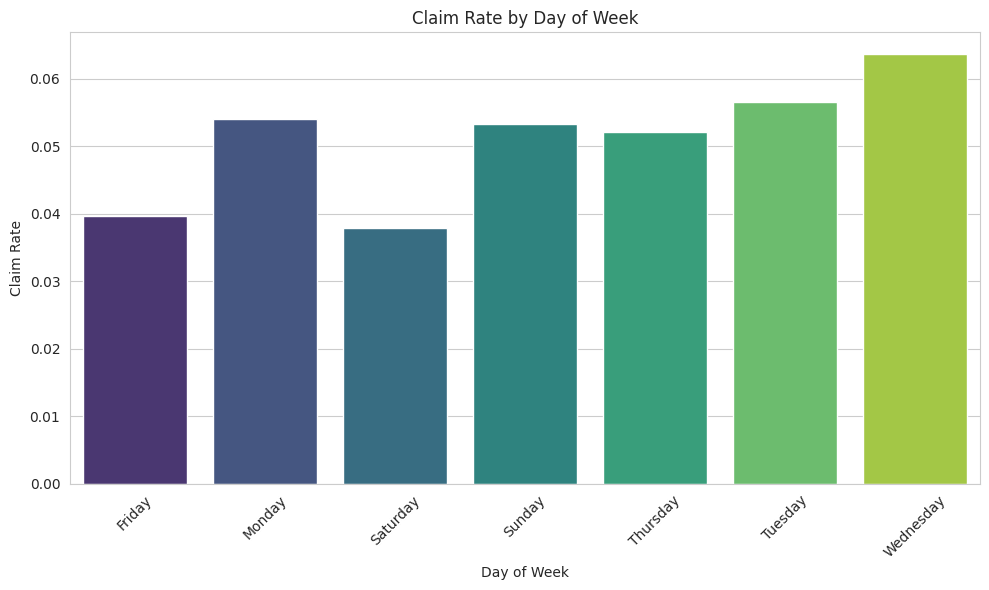

/tmp/ipython-input-8-1548887726.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour_bin', y='is_claimed', data=hour_of_day_analysis, palette='viridis')


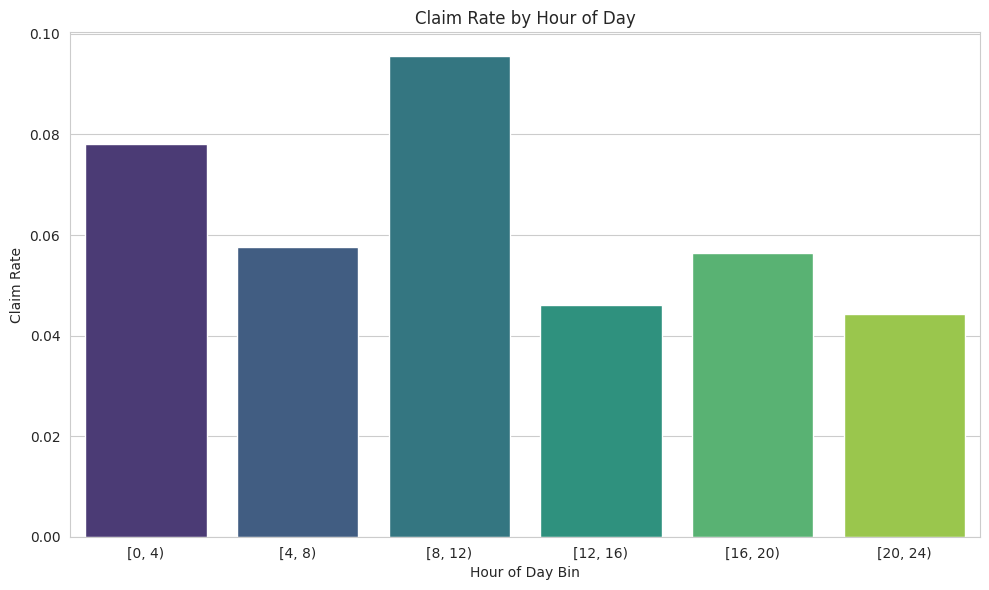

/tmp/ipython-input-8-1548887726.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lead_time_bin', y='is_claimed', data=lead_time_analysis, palette='viridis')


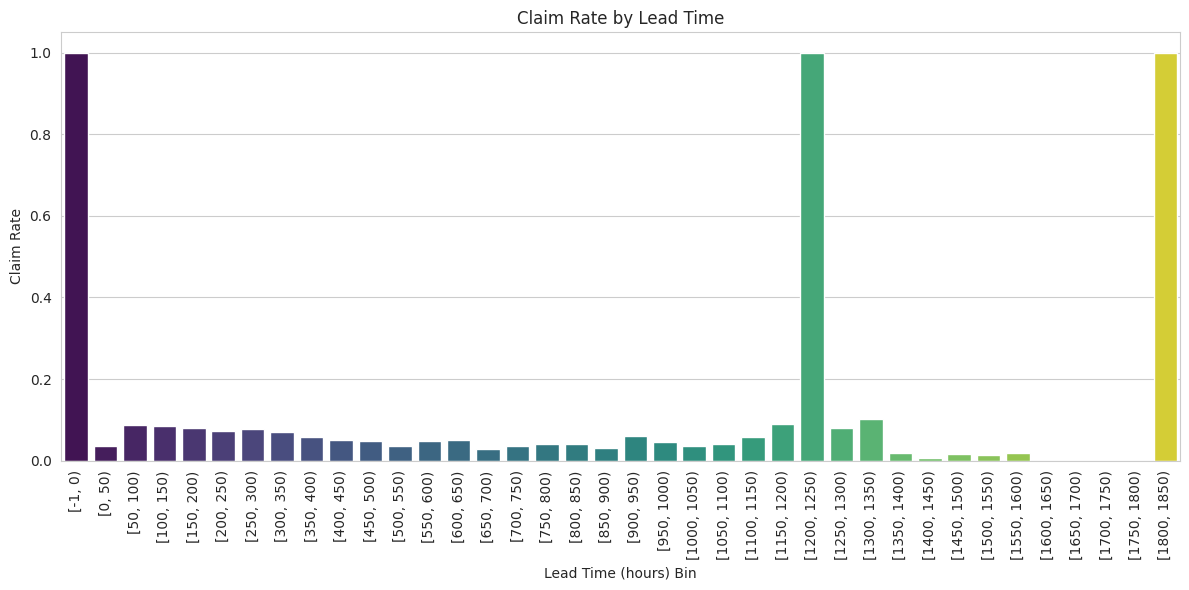

/tmp/ipython-input-8-1548887726.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pay_rate_bin', y='is_claimed', data=pay_rate_analysis, palette='viridis')


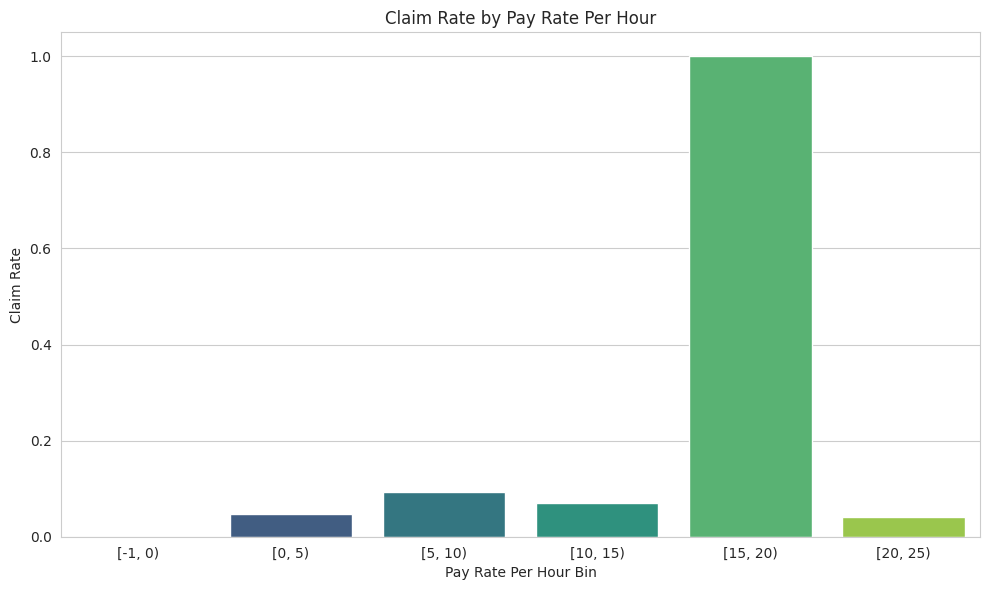

/tmp/ipython-input-8-1548887726.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='charge_rate_bin', y='is_claimed', data=charge_rate_analysis, palette='viridis')


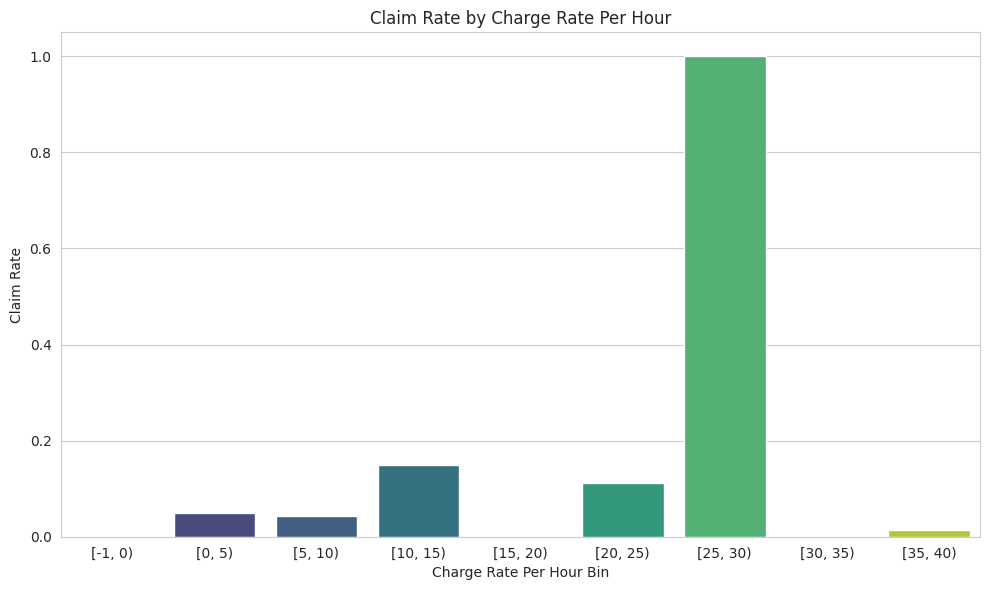

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot Claim Rate by Day of Week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='is_claimed', data=day_of_week_analysis, palette='viridis')
plt.title('Claim Rate by Day of Week')
plt.ylabel('Claim Rate')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Claim Rate by Hour of Day Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='hour_bin', y='is_claimed', data=hour_of_day_analysis, palette='viridis')
plt.title('Claim Rate by Hour of Day')
plt.ylabel('Claim Rate')
plt.xlabel('Hour of Day Bin')
plt.tight_layout()
plt.show()

# Plot Claim Rate by Lead Time Bin
plt.figure(figsize=(12, 6))
sns.barplot(x='lead_time_bin', y='is_claimed', data=lead_time_analysis, palette='viridis')
plt.title('Claim Rate by Lead Time')
plt.ylabel('Claim Rate')
plt.xlabel('Lead Time (hours) Bin')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot Claim Rate by Pay Rate Per Hour Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='pay_rate_bin', y='is_claimed', data=pay_rate_analysis, palette='viridis')
plt.title('Claim Rate by Pay Rate Per Hour')
plt.ylabel('Claim Rate')
plt.xlabel('Pay Rate Per Hour Bin')
plt.tight_layout()
plt.show()

# Plot Claim Rate by Charge Rate Per Hour Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='charge_rate_bin', y='is_claimed', data=charge_rate_analysis, palette='viridis')
plt.title('Claim Rate by Charge Rate Per Hour')
plt.ylabel('Claim Rate')
plt.xlabel('Charge Rate Per Hour Bin')
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
import numpy as np

# Load the data
file_path = '/content/Problems we tackle, Shift Offers v3.xlsx'
df = pd.read_excel(file_path)

# Data Cleaning and Preprocessing
datetime_columns = ['SHIFT_START_AT', 'SHIFT_CREATED_AT', 'OFFER_VIEWED_AT', 'CLAIMED_AT', 'DELETED_AT', 'CANCELED_AT']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

df.drop_duplicates(inplace=True)

# Feature Engineering
df['lead_time_hours'] = (df['SHIFT_START_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['day_of_week'] = df['SHIFT_START_AT'].dt.day_name()
df['hour_of_day'] = df['SHIFT_START_AT'].dt.hour
df['view_time_hours'] = (df['OFFER_VIEWED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['view_time_hours'].fillna(-1, inplace=True)
df['claim_time_hours'] = (df['CLAIMED_AT'] - df['OFFER_VIEWED_AT']).dt.total_seconds() / 3600
df['claim_time_hours'].fillna(-1, inplace=True)
df['claim_from_created_time_hours'] = (df['CLAIMED_AT'] - df['SHIFT_CREATED_AT']).dt.total_seconds() / 3600
df['claim_from_created_time_hours'].fillna(-1, inplace=True)
df['pay_rate_per_hour'] = df['PAY_RATE'] / df['DURATION']
df['charge_rate_per_hour'] = df['CHARGE_RATE'] / df['DURATION']

# Analyze shift offer acceptance/rejection and prepare data for plotting
df['is_viewed'] = df['OFFER_VIEWED_AT'].notna()
df['is_claimed'] = df['CLAIMED_AT'].notna()
df['is_canceled'] = df['CANCELED_AT'].notna()

day_of_week_analysis = df.groupby('day_of_week')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

hour_bins = range(0, 28, 4)
df['hour_bin'] = pd.cut(df['hour_of_day'], bins=hour_bins, right=False, include_lowest=True)
hour_of_day_analysis = df.groupby('hour_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

lead_time_bins = [-1] + list(range(0, int(df['lead_time_hours'].max()) + 50, 50))
df['lead_time_bin'] = pd.cut(df['lead_time_hours'], bins=lead_time_bins, right=False, include_lowest=True)
lead_time_analysis = df.groupby('lead_time_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning pay rate
max_finite_pay_rate = df[np.isfinite(df['pay_rate_per_hour'])]['pay_rate_per_hour'].max()
df['pay_rate_per_hour'] = np.where(np.isinf(df['pay_rate_per_hour']), max_finite_pay_rate, df['pay_rate_per_hour'])
pay_rate_bins = [-1] + list(range(0, int(df['pay_rate_per_hour'].max()) + 5, 5))
df['pay_rate_bin'] = pd.cut(df['pay_rate_per_hour'], bins=pay_rate_bins, right=False, include_lowest=True)
pay_rate_analysis = df.groupby('pay_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

# Handle infinite values before binning charge rate
max_finite_charge_rate = df[np.isfinite(df['charge_rate_per_hour'])]['charge_rate_per_hour'].max()
df['charge_rate_per_hour'] = np.where(np.isinf(df['charge_rate_per_hour']), max_finite_charge_rate, df['charge_rate_per_hour'])
charge_rate_bins = [-1] + list(range(0, int(df['charge_rate_per_hour'].max()) + 5, 5))
df['charge_rate_bin'] = pd.cut(df['charge_rate_per_hour'], bins=charge_rate_bins, right=False, include_lowest=True)
charge_rate_analysis = df.groupby('charge_rate_bin')[['is_viewed', 'is_claimed', 'is_canceled']].mean().reset_index()

/tmp/ipython-input-10-1324187734.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['view_time_hours'].fillna(-1, inplace=True)
/tmp/ipython-input-10-1324187734.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

/tmp/ipython-input-11-1548887726.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='is_claimed', data=day_of_week_analysis, palette='viridis')


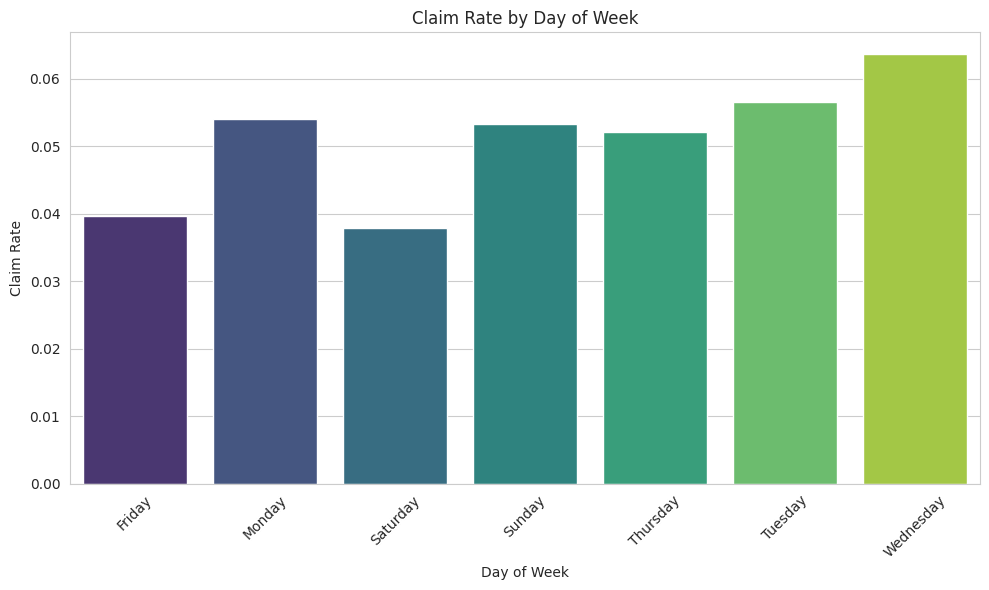

/tmp/ipython-input-11-1548887726.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hour_bin', y='is_claimed', data=hour_of_day_analysis, palette='viridis')


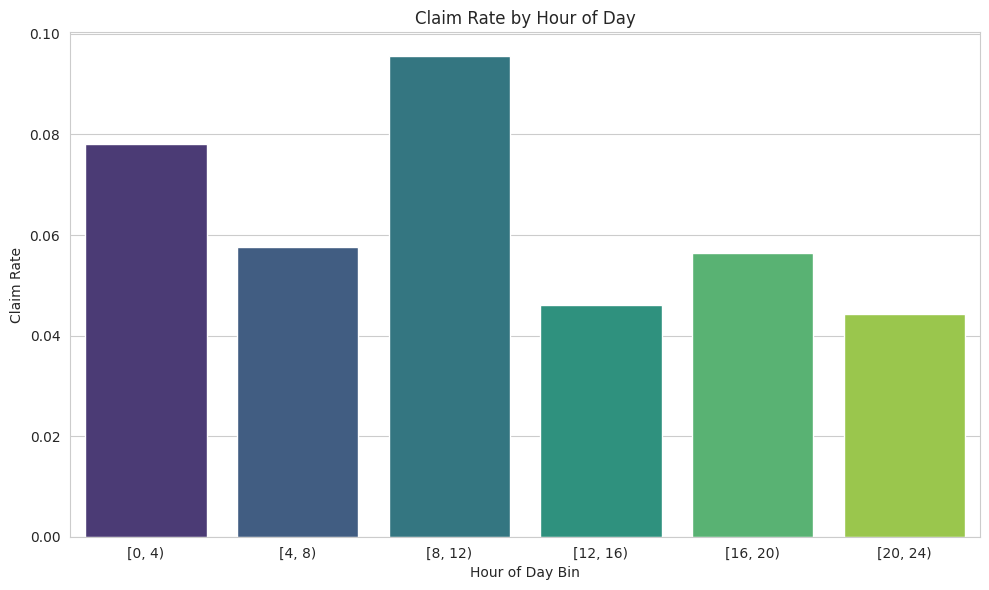

/tmp/ipython-input-11-1548887726.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lead_time_bin', y='is_claimed', data=lead_time_analysis, palette='viridis')


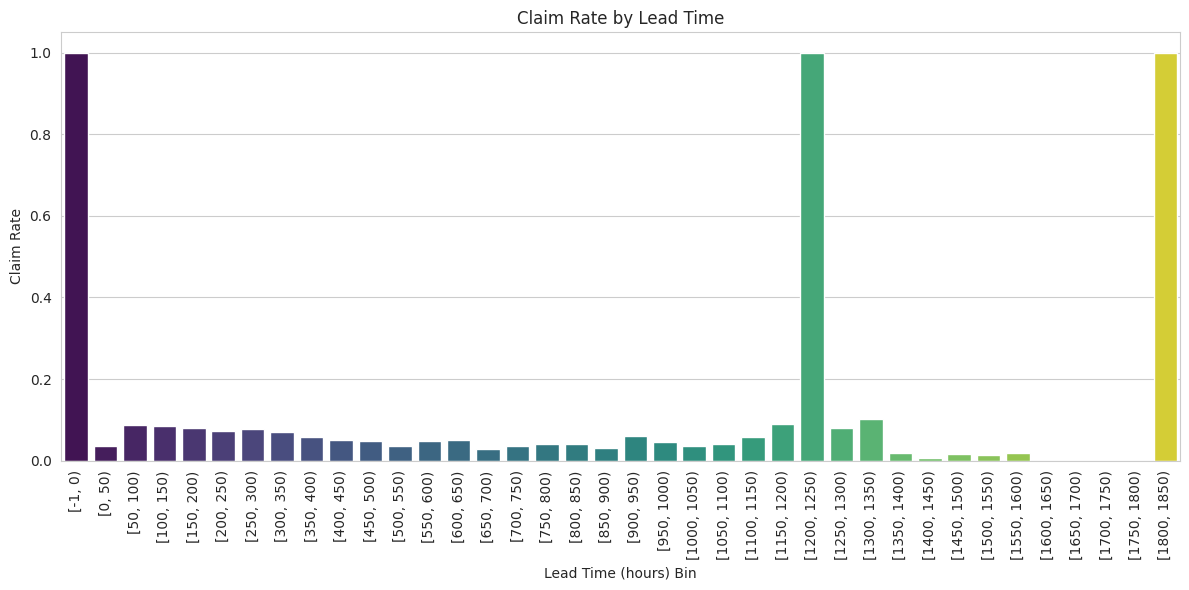

/tmp/ipython-input-11-1548887726.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pay_rate_bin', y='is_claimed', data=pay_rate_analysis, palette='viridis')


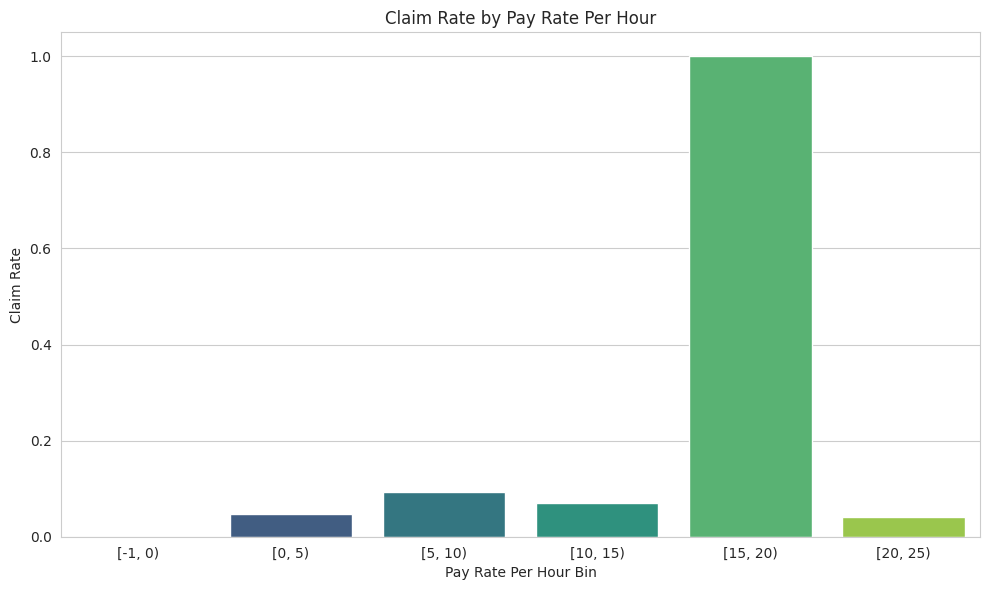

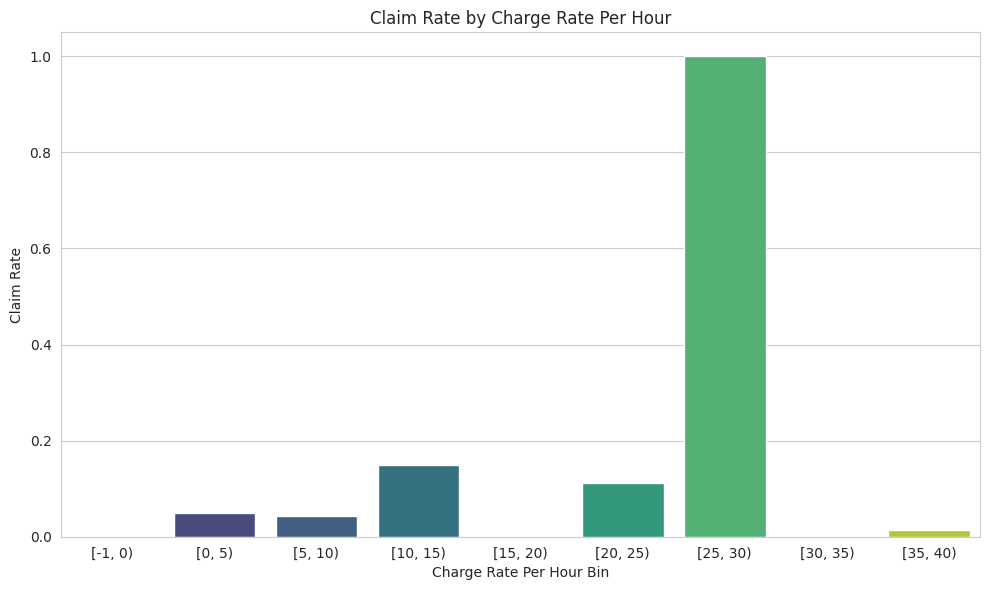

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot Claim Rate by Day of Week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='is_claimed', data=day_of_week_analysis, palette='viridis')
plt.title('Claim Rate by Day of Week')
plt.ylabel('Claim Rate')
plt.xlabel('Day of Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Claim Rate by Hour of Day Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='hour_bin', y='is_claimed', data=hour_of_day_analysis, palette='viridis')
plt.title('Claim Rate by Hour of Day')
plt.ylabel('Claim Rate')
plt.xlabel('Hour of Day Bin')
plt.tight_layout()
plt.show()

# Plot Claim Rate by Lead Time Bin
plt.figure(figsize=(12, 6))
sns.barplot(x='lead_time_bin', y='is_claimed', data=lead_time_analysis, palette='viridis')
plt.title('Claim Rate by Lead Time')
plt.ylabel('Claim Rate')
plt.xlabel('Lead Time (hours) Bin')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot Claim Rate by Pay Rate Per Hour Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='pay_rate_bin', y='is_claimed', data=pay_rate_analysis, palette='viridis')
plt.title('Claim Rate by Pay Rate Per Hour')
plt.ylabel('Claim Rate')
plt.xlabel('Pay Rate Per Hour Bin')
plt.tight_layout()
plt.show()

# Plot Claim Rate by Charge Rate Per Hour Bin
plt.figure(figsize=(10, 6))
sns.barplot(x='charge_rate_bin', y='is_claimed', data=charge_rate_analysis, palette='viridis')
plt.title('Claim Rate by Charge Rate Per Hour')
plt.ylabel('Claim Rate')
plt.xlabel('Charge Rate Per Hour Bin')
plt.tight_layout()
plt.show()